### Candidate Numbers : 44026, 39639, 50100 ###

# Impact of Macroeconomic Indicators on Business Sectors in the U.S. Stock Market Since 2000 #

## Table of Contents ##

1. Introduction

2. Acquiring and pre-processing data

* Economic Data
* Sector-specific Financial Data

3. Analysis of sector performance

* Era 1 (2000-2008)
* Era 2 (2008-2020)
* Era 3 (2020-2024)

4. Relationship Analysis of Macroeconomic indicators and Business sector performnace

* CPI (Consumer Price Index)
* Retail Sales
* Home Price Index

5. Regression Modelling

* Model 1: Impact of Retail Sales on Materials Sector
* Model 2: Impact of Consumer Price Index on Consumer Staples
* Model 3: Impact of Home Price Index and Real GDP on Real Estate Sector

6. Conclusion

### 1. Introduction ###

The U.S. stock market, a cornerstone of the global financial system, reflects the dynamic interplay between macroeconomic conditions and business sector performance. Since 2000, the market has experienced a series of significant economic shifts, from the dot-com bubble and the 2008 financial crisis to periods of recovery and sustained growth. Understanding how macroeconomic indicators influence different business sectors is crucial for policymakers, investors, and industry stakeholders seeking to navigate these fluctuations effectively. This project explores the impact of macroeconomic indicators on U.S. business sectors, focusing on how economic factors have shaped sector performance over the past two decades. The objectives are threefold: first, to analyse the performance of business sectors during key economic phases—such as expansions, recessions, and recoveries—highlighting sector resilience and adaptability under varying macroeconomic conditions; second, to examine the relationship between macroeconomic indicators like the unemployment rate, CPI, Federal Funds Rate, Real GDP, and consumer sentiment, identifying the most influential factors and their impact on specific sectors; and third, to develop a simple, data-driven model that predicts how changes in these indicators could influence sector performance. By integrating historical data with statistical techniques, this study provides a framework for evaluating the relationship between macroeconomic conditions and stock market performance, offering practical insights for informed decision-making.

### 2.0 Acquiring and pre-processing data ###

The data was gathered and pre-processed through a series of steps to ensure comprehensive coverage of over two decades of economic and financial information, making it ready for analysis. First, a date range from January 1, 2000, to December 31, 2024, was set to filter the data. A list of key economic indicators, such as the Unemployment Rate, CPI, Fed Funds Rate, Real GDP, Consumer Sentiment, Industrial Production, Retail Sales, Home Price Index, Crude Oil, and EUR/USD Exchange Rate, was mapped to their specific FRED series IDs. Using a custom function, each of these indicators was downloaded from the FRED website in CSV format and limited to the defined date range.

Since the data sources had different frequencies—some were daily, others monthly or quarterly—daily data such as Crude Oil prices and EUR/USD exchange rates were resampled to monthly intervals by taking the last value of each month. For quarterly data, such as Real GDP, the values were forward-filled to create a consistent monthly dataset.

All the individual datasets were then merged into a single comprehensive DataFrame based on their dates. To make the column names more intuitive, they were renamed from their FRED codes to descriptive names, such as "Unemployment_Rate" and "CPI." The combined data was saved as a CSV file for easy access. Next, any missing values were addressed by first forward-filling and then backward-filling to ensure no gaps remained, particularly in the Real GDP data, where some months were intentionally set to NaN and later interpolated.

In addition to economic indicators, sector-specific financial data was pulled from Yahoo Finance using its API. This included both sector ETFs and representative stocks for sectors like Communication Services and Real Estate, as these two sectors lacked indices dating back to 2000. Companies like AT&T, Disney, Netflix, Verizon, and Comcast were chosen to represent the Communication Services sector, while American Tower Corporation, Prologis, Simon Property Group, Equinix, and Public Storage were selected for the Real Estate sector. Each stock’s adjusted closing prices were downloaded and used to build sector indices by calculating daily returns, averaging them for equal weighting, and then computing cumulative returns. The daily returns were then resampled by taking the last available value of each month to create a dataset with monthly granularity to allign with macroeconomic data frequencies. Lastly, these sector indices were normalised to start at 100 for easier comparison and rounded to two decimal places for clarity.

Finally, the economic and business sector datasets were combined into a single comprehensive DataFrame. The cleaned and finalised dataset was saved as a CSV file, ready for further analysis.



In [46]:
# Loading libraries

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.colors as mcolors  
import warnings
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### 2.1 Economic Data ###

In [32]:
# Define start and end date for filtering after download
start_date = "2000-01-01"
end_date = "2024-12-31"

# A dictionary of indicator names mapped to their FRED series IDs

fred_series = {
    "Unemployment_Rate": "UNRATE",                  # Monthly, %
    "CPI": "CPIAUCSL",                              # Monthly CPI index
    "Fed_Funds_Rate": "FEDFUNDS",                   # Monthly avg % rate
    "Real_GDP": "GDPC1",                            # Quarterly real GDP
    "Consumer_Sentiment": "UMCSENT",                # Monthly consumer sentiment as proxy for confidence
    "Industrial_Production": "INDPRO",              # Monthly IP index
    "Retail_Sales": "RSAFS",                        # Monthly retail sales
    "Home_Price_Index": "CSUSHPINSA",               # Monthly Case-Shiller home price index
    "Crude_Oil_WTI": "DCOILWTICO",                  # Daily WTI oil price
    "EUR_USD_Exchange_Rate": "DEXUSEU"              # Daily EUR to USD exchange rate
}

def download_fred_data(series_id):
    """
    Downloads data from FRED in CSV format using a direct URL pattern.
    Returns a DataFrame with a datetime index and a single column of values.
    """
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    df = pd.read_csv(url, parse_dates=["observation_date"])
    df.set_index("observation_date", inplace=True)
    df.columns = [series_id]
    return df

# Download data for each series and store in a dictionary of DataFrames
data_frames = {}
for name, sid in fred_series.items():
    print(f"Downloading {name} ({sid})...")
    df = download_fred_data(sid)
    # Filter by date range
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]
    data_frames[name] = df

# Alligning frequencies
for name in ["Crude_Oil_WTI", "EUR_USD_Exchange_Rate"]:
    if name in data_frames:
        data_frames[name] = data_frames[name].resample('M').last()  # using last available value in each month

# For quarterly GDP data I am using forward fill to get a monthly frequency (the same value for all months in the quarter)
if "Real_GDP" in data_frames:
    # Forward fill monthly so each month in the quarter carries the latest GDP value
    data_frames["Real_GDP"] = data_frames["Real_GDP"].resample('M').ffill()
    

# Merge all dataframes on the index (Date)
combined_df = None
for name, df in data_frames.items():
    if combined_df is None:
        combined_df = df
    else:
        combined_df = combined_df.join(df, how='outer')

# Renaming columns to be more descriptive
column_map = {fred_series[k]: k for k in fred_series.keys()}
combined_df.rename(columns=column_map, inplace=True)

# Exporting to CSV
combined_df.to_csv("/tmp/us_macro_data_2000_2024.csv")


print("Data successfully saved to us_macro_data_2000_2024.csv")

Data successfully saved to us_macro_data_2000_2024.csv


In [33]:
combined_df.head()

Unemployment_Rate    CPI  Fed_Funds_Rate   Real_GDP  \
observation_date                                                        
2000-01-01                      4.0  169.3            5.45        NaN   
2000-01-31                      NaN    NaN             NaN  13878.147   
2000-02-01                      4.1  170.0            5.73        NaN   
2000-02-29                      NaN    NaN             NaN  13878.147   
2000-03-01                      4.0  171.0            5.85        NaN   

                  Consumer_Sentiment  Industrial_Production  Retail_Sales  \
observation_date                                                            
2000-01-01                     112.0                91.4092      268044.0   
2000-01-31                       NaN                    NaN           NaN   
2000-02-01                     111.3                91.7245      272020.0   
2000-02-29                       NaN                    NaN           NaN   
2000-03-01                     107.1                92.0830      275192.0   

                  Home_Price_Index  Crude_Oil_WTI  EUR_USD_Exchange_Rate  
observation_date                                                          
2000-01-01                 100.000            NaN                    NaN  
2000-01-31                     NaN          27.65                 0.9757  
2000-02-01                 100.571            NaN                    NaN  
2000-02-29                     NaN          30.57                 0.9643  
2000-03-01                 101.466            NaN                    NaN

In [34]:
# Converting index to monthly periods
combined_df.index = combined_df.index.to_period('M')


# Grouping by the monthly period and combining the data
def fill_month_data(group):
    # Forward fill then backward fill within the monthly group to eliminate NaNs
    return group.ffill().bfill()

filled = combined_df.groupby(level=0).apply(fill_month_data)

monthly_df = filled.groupby(level=0).last()

# Converting the PeriodIndex back to a Timestamp 
monthly_df.index = monthly_df.index.to_timestamp('M')

# Saving the result
monthly_df.to_csv("us_macro_data_monthly_aligned.csv")

In [35]:
# Calculating the number of missing values per column
missing_values = monthly_df.isnull().sum()

# Filtering columns that have missing values
missing_values = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
print(missing_values)

Columns with missing values and their counts:
Unemployment_Rate        1
CPI                      1
Fed_Funds_Rate           1
Real_GDP                 5
Consumer_Sentiment       2
Industrial_Production    2
Retail_Sales             2
Home_Price_Index         3
dtype: int64


In [36]:
# modifying the original DataFrame in place
monthly_df.fillna(method='ffill', inplace=True)

In [37]:
# Define months to set as NaN
months_to_nan = [2, 3, 5, 6, 8, 9, 11, 12]

# Replace specified months with NaN
monthly_df.loc[monthly_df.index.month.isin(months_to_nan), 'Real_GDP'] = np.nan

# Interpolate missing values
monthly_df['Real_GDP'] = monthly_df['Real_GDP'].interpolate(method='time')


monthly_df.head()

Unemployment_Rate    CPI  Fed_Funds_Rate      Real_GDP  \
observation_date                                                           
2000-01-31                      4.0  169.3            5.45  13878.147000   
2000-02-29                      4.1  170.0            5.73  13959.592211   
2000-03-31                      4.0  171.0            5.85  14046.654333   
2000-04-30                      3.8  170.9            6.02  14130.908000   
2000-05-31                      4.0  171.2            6.27  14135.761522   

                  Consumer_Sentiment  Industrial_Production  Retail_Sales  \
observation_date                                                            
2000-01-31                     112.0                91.4092      268044.0   
2000-02-29                     111.3                91.7245      272020.0   
2000-03-31                     107.1                92.0830      275192.0   
2000-04-30                     109.2                92.6659      271046.0   
2000-05-31                     110.7                92.9347      271394.0   

                  Home_Price_Index  Crude_Oil_WTI  EUR_USD_Exchange_Rate  
observation_date                                                          
2000-01-31                 100.000          27.65                 0.9757  
2000-02-29                 100.571          30.57                 0.9643  
2000-03-31                 101.466          26.86                 0.9574  
2000-04-30                 102.541          25.71                 0.9089  
2000-05-31                 103.702          29.03                 0.9328

In [38]:
# columns to round
columns_to_round = ['Real_GDP', 'Industrial_Production', 'Home_Price_Index', 'EUR_USD_Exchange_Rate']

# Rounding the specified columns to 2 decimal places
monthly_df[columns_to_round] = monthly_df[columns_to_round].round(2)

In [39]:
# Saving data
monthly_df.reset_index().to_csv('economic_indicators.csv', index=False)

### 2.2 Sector-specific Financial Data ###

In [40]:
# Defining the list of sector ETFs based on GICS 
sector_etfs = {
    
    'Materials': 'XLB',                       
    'Energy': 'XLE',                          
    'Financials': 'XLF',                      
    'Industrials': 'XLI',                     
    'Technology': 'XLK',                      
    'Consumer Staples': 'XLP',                
    'Utilities': 'XLU',                       
    'Health Care': 'XLV',                     
    'Consumer Discretionary': 'XLY'           
}

# the date range
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# empty DataFrame to store adjusted close prices
sector_data = pd.DataFrame()

# Function to download data and handle exceptions
def download_sector_data(sector, ticker, start, end):
    print(f"Downloading data for {sector} ({ticker})...")
    try:
        data = yf.download(ticker, start=start, end=end, progress=False)
        if data.empty:
            print(f"Warning: No data found for {ticker}. Skipping...")
            return None
        return data['Adj Close']
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

# Downloading data for each sector ETF
for sector, ticker in sector_etfs.items():
    adj_close = download_sector_data(sector, ticker, start_date, end_date)
    if adj_close is not None:
        sector_data[sector] = adj_close


# the first few rows of the collected data
sector_data.head()

Materials     Energy  Financials  Industrials  Technology  \
Date                                                                    
2000-01-03  14.887234  13.962523   11.351280    18.467203   41.629463   
2000-01-04  14.743911  13.699697   10.855048    17.957001   39.517490   
2000-01-05  15.353011  14.061080   10.769757    17.876970   38.930832   
2000-01-06  15.747142  14.603150   11.242732    18.117067   37.640175   
2000-01-07  15.738176  14.759211   11.428814    18.807333   38.297234   

            Consumer Staples  Utilities  Health Care  Consumer Discretionary  
Date                                                                          
2000-01-03         12.635743  11.514973    20.980354               22.582930  
2000-01-04         12.279931  11.167623    20.504267               21.903555  
2000-01-05         12.496892  11.449439    20.320320               21.634174  
2000-01-06         12.731205  11.429770    20.385250               21.880133  
2000-01-07         13.538295  11.528080    20.634102               22.910894

In [41]:
# Defining the list of representative stocks for each sector
sector_stocks = {
    'Communication Services': ['T', 'VZ', 'DIS', 'CMCSA', 'NFLX'],
    'Real Estate': ['AMT', 'PLD', 'SPG', 'EQIX', 'PSA']
}

# the date range
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to download adjusted close prices
def get_adjusted_close(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, progress=False)['Adj Close']
    return data

# DataFrame to store sector indices
sector_indices = pd.DataFrame()

# Iterate over each sector
for sector, tickers in sector_stocks.items():
    print(f"Constructing index for {sector} sector...")
    
    # Download data for the sector's stocks
    adj_close = get_adjusted_close(tickers, start_date, end_date)
    
    # Drop rows with all NaNs
    adj_close.dropna(how='all', inplace=True)
    
    # Handle missing data by forward filling, then backward filling
    adj_close.fillna(method='ffill', inplace=True)
    adj_close.fillna(method='bfill', inplace=True)
    
    # Calculate daily returns
    daily_returns = adj_close.pct_change().dropna()
    
    # Calculate mean daily return for equal weighting
    mean_daily_return = daily_returns.mean(axis=1)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + mean_daily_return).cumprod()
    
    # Add to sector_indices DataFrame
    sector_indices[sector] = cumulative_returns

# Display sample data
print("\nSample of constructed sector indices:")
print(sector_indices.head())

Constructing index for Communication Services sector...
Constructing index for Real Estate sector...

Sample of constructed sector indices:
            Communication Services  Real Estate
Date                                           
2000-01-04                0.978575     0.992503
2000-01-05                0.991185     0.999247
2000-01-06                0.986085     1.013656
2000-01-07                0.977003     1.040101
2000-01-10                1.033626     1.066211


In [42]:
# Using pd.concat for merging on the index
combined_sector_data = pd.concat([sector_indices, sector_data], axis=1, join='outer')

In [43]:
# Removing the first row
combined_sector_data = combined_sector_data.iloc[1:]

# Resampling to monthly frequency, taking the last available value in each month
monthly_sector_data = combined_sector_data.resample('M').last()

# Normalising all variables to start at 100
columns_to_normalize = monthly_sector_data.columns.tolist()

monthly_sector_data[columns_to_normalize] = monthly_sector_data[columns_to_normalize].apply(
    lambda x: (x / x.iloc[0]) * 100
)

# Rounding all variables to 2 decimal places
monthly_sector_data = monthly_sector_data.round(2)

monthly_sector_data.head()

Communication Services  Real Estate  Materials  Energy  \
Date                                                                 
2000-01-31                  100.00       100.00     100.00  100.00   
2000-02-29                   90.90       105.31      89.95   95.77   
2000-03-31                  102.26       106.37      99.03  107.68   
2000-04-30                  103.52       109.69      95.74  106.08   
2000-05-31                  100.01       105.05      92.72  118.53   

            Financials  Industrials  Technology  Consumer Staples  Utilities  \
Date                                                                           
2000-01-31      100.00       100.00      100.00            100.00     100.00   
2000-02-29       89.30        94.48      110.51             88.30      87.85   
2000-03-31      105.60       107.64      119.78             91.62      97.44   
2000-04-30      106.62       109.19      108.78             96.48     103.82   
2000-05-31      109.00       108.73       97.47            103.36     103.59   

            Health Care  Consumer Discretionary  
Date                                             
2000-01-31       100.00                  100.00  
2000-02-29        93.46                   94.43  
2000-03-31       101.87                  107.79  
2000-04-30       100.67                  105.55  
2000-05-31        97.98                   99.85

In [44]:
# Saving the modified DataFrame
monthly_sector_data.to_csv('business_sector_data.csv')

In [45]:
sector_data = pd.read_csv('business_sector_data.csv')
econ_data = pd.read_csv('economic_indicators.csv')

In [46]:
# Using pd.concat for merging on the index
combined_data = pd.concat([econ_data, sector_data], axis=1, join='outer')

In [49]:
# Assuming combined_data is your DataFrame
combined_data = combined_data.drop('Date', axis=1)

In [52]:
# Saving the combined DataFrame
combined_data.to_csv('cleaned_combined_data.csv')

# 3.0 Analysis of sector performance #

In [3]:
# Loading dataset
data = pd.read_csv('cleaned_combined_data.csv')

# 'DATE' column to datetime
data['observation_date'] = pd.to_datetime(data['observation_date'])

# Sorting the data by date in ascending order
data.sort_values('observation_date', inplace=True)

# 'observation_date' as the index
data.set_index('observation_date', inplace=True)


In [4]:
# figure and axis
plt.figure(figsize=(14, 7))

# Ploting Real GDP 
sns.lineplot(x=data.index, y='Real_GDP', data=data, color='blue', linewidth=2, label='Real GDP')

# Highlighting specific events 
events = {
    '2008 Financial Crisis': '2008-06-01',
    'COVID-19 Pandemic': '2020-01-01'
}

for event, date in events.items():
    # Convert date string to datetime
    event_date = pd.to_datetime(date)
    
    # vertical line
    plt.axvline(event_date, color='red', linestyle='--', linewidth=1.5)
    
    # current y-axis limits
    ymin, ymax = plt.ylim()
    
    # vertical alignment and y-position based on the event
    if event == '2008 Financial Crisis':
        va = 'top'
        y_position = ymax * 0.95  # Near the top
    elif event == 'COVID-19 Pandemic':
        va = 'bottom'
        y_position = ymin + (ymax - ymin) * 0.05  # Near the bottom
    else:
        va = 'center'
        y_position = (ymax + ymin) / 2  # Default center position
    
    # text annotation 
    plt.text(event_date, y_position, event, rotation=90, verticalalignment=va, color='red', fontsize=12)

# Adding title and labels
plt.title('Real GDP Over Time with Key Economic Events (2000–2024)', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Real GDP (in Billions)', fontsize=16)

# Defining the date format
date_format = mdates.DateFormatter('%Y')

# Setting ticks to every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(date_format)

# Rotating x-axis labels 
plt.xticks(rotation=45, fontsize=12)

# Increasing y-axis label font size
plt.yticks(fontsize=12)

# legend with increased font size
plt.legend(fontsize=12)

# Adjust layout 
plt.tight_layout()

# Show the plot
plt.show()


The plot of U.S. real GDP from 2000 to 2024 reveals a generally upward trend, punctuated by two significant disruptions: the Financial Crisis of 2008-2009 and the COVID-19 pandemic in 2020. From 2000 until mid-2008, real GDP grew steadily, reflecting a robust economic expansion. However, the Financial Crisis caused a sharp contraction in real GDP, with the downturn lasting from mid-2008 to mid-2009. This period marked one of the most severe economic declines in recent history. Following the crisis, the economy rebounded, entering a prolonged phase of growth that persisted until early 2020. The onset of the COVID-19 pandemic then triggered another dramatic fall in real GDP, driven by widespread lockdowns and disruptions to global supply chains. Despite this, the recovery was remarkably swift, supported by aggressive fiscal and monetary policy interventions. Real GDP has since resumed its upward trajectory, demonstrating the resilience of the U.S. economy in the face of significant shocks. 

For the first part of our analysis, we will examine business sector performance during three eras: Era 1, the pre-financial crisis period (2000–2008); Era 2, the financial crisis and recovery period (2008–2020); and Era 3, the COVID pandemic and post-COVID period (2020–2024).

In [5]:
# Defining era date ranges
era1_start = '2000-01-01'
era1_end = '2008-06-01'

era2_start = '2008-06-01'
era2_end = '2020-01-01'

era3_start = '2020-01-01'
era3_end = '2024-12-01'

# Filtering data for each era
era1_data = data.loc[era1_start:era1_end]
era2_data = data.loc[era2_start:era2_end]
era3_data = data.loc[era3_start:era3_end]


In [6]:
# Defining sector columns
sector_columns = [
    'Communication Services', 'Real Estate', 'Materials', 'Energy',
    'Financials', 'Industrials', 'Technology', 'Consumer Staples',
    'Utilities', 'Health Care', 'Consumer Discretionary'
]

# Function to normalize sector data
def normalize_era(era_df, sector_cols):
    return era_df[sector_cols].div(era_df[sector_cols].iloc[0]).mul(100)

# Normalize each era
era1_norm = normalize_era(era1_data, sector_columns)
era2_norm = normalize_era(era2_data, sector_columns)
era3_norm = normalize_era(era3_data, sector_columns)


In [7]:
# Assign a color palette with sufficient distinct colors
palette = sns.color_palette("tab20", len(sector_columns))  

# Creating a dictionary mapping each sector to a color
sector_colors = {sector: palette[i] for i, sector in enumerate(sector_columns)}

# Convert the seaborn palette to hexadecimal colors for Plotly using matplotlib.colors.to_hex
sector_colors_hex = {sector: mcolors.to_hex(color) for sector, color in sector_colors.items()}


In [8]:
# Function to compute log returns
def compute_log_returns(era_norm_df):
    return np.log(era_norm_df / era_norm_df.shift(1)).dropna()

# Compute log returns for each era
era1_returns = compute_log_returns(era1_norm)
era2_returns = compute_log_returns(era2_norm)
era3_returns = compute_log_returns(era3_norm)

# Function to compute average return and risk
def compute_stats(returns_df):
    avg_return = returns_df.mean() * 12  # Annualize the average monthly return
    risk = returns_df.std() * np.sqrt(12)  # Annualize the standard deviation
    return avg_return, risk

# Compute stats for each era
era1_avg_return, era1_risk = compute_stats(era1_returns)
era2_avg_return, era2_risk = compute_stats(era2_returns)
era3_avg_return, era3_risk = compute_stats(era3_returns)


In [9]:
# Function to create stats dataframe
def create_stats_df(avg_return, risk, period_label):
    return pd.DataFrame({
        'Sector': avg_return.index,
        'Period': period_label,
        'Return': avg_return.values,
        'Risk': risk.values
    })

# Create stats dataframes for each era
era1_stats = create_stats_df(era1_avg_return, era1_risk, '2000-2008')
era2_stats = create_stats_df(era2_avg_return, era2_risk, '2008-2020')
era3_stats = create_stats_df(era3_avg_return, era3_risk, '2020-2024')

# Combine all eras into a single DataFrame
full_data = pd.concat([era1_stats, era2_stats, era3_stats], ignore_index=True)


In [10]:
# Defining estimated market caps for each era
market_caps_era1 = pd.DataFrame({
    'Sector': sector_columns,
    'Period': '2000-2008',
    'Market Cap (Trillion USD)': [
        0.60, 0.60, 0.45, 0.60,
        2.25, 1.80, 1.50, 1.05,
        0.45, 1.80, 2.40
    ]
})

market_caps_era2 = pd.DataFrame({
    'Sector': sector_columns,
    'Period': '2008-2020',
    'Market Cap (Trillion USD)': [
        3.00, 0.90, 0.60, 0.60,
        3.30, 2.40, 8.10, 1.80,
        0.60, 3.90, 4.80
    ]
})

market_caps_era3 = pd.DataFrame({
    'Sector': sector_columns,
    'Period': '2020-2024',
    'Market Cap (Trillion USD)': [
        4.40, 0.80, 0.80, 1.20,
        4.00, 2.80, 12.00, 2.00,
        0.80, 5.20, 6.80
    ]
})

# Combining all market cap data
all_market_caps = pd.concat([market_caps_era1, market_caps_era2, market_caps_era3], ignore_index=True)

# Merging the market cap data with full_data
full_data_with_market_cap = pd.merge(
    full_data,
    all_market_caps,
    on=['Sector', 'Period'],
    how='left'
)

# Displaying the combined DataFrame
full_data_with_market_cap.head()


Sector     Period    Return      Risk  \
0  Communication Services  2000-2008  0.078635  0.191769   
1             Real Estate  2000-2008  0.190385  0.314944   
2               Materials  2000-2008  0.100885  0.188060   
3                  Energy  2000-2008  0.152933  0.205274   
4              Financials  2000-2008  0.029219  0.168447   

   Market Cap (Trillion USD)  
0                       0.60  
1                       0.60  
2                       0.45  
3                       0.60  
4                       2.25

In [11]:
# Function to calculate maximum drawdown for a pandas Series
def calculate_max_drawdown(series):
    """
    Calculate the maximum drawdown of a time series.

    Parameters:
    series (pd.Series): The time series data.

    Returns:
    float: The maximum drawdown as a positive percentage.
    """
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()  # This will be negative
    return abs(max_drawdown) * 100  # Convert to positive percentage

# Calculate maximum drawdown for each sector in each era
def get_max_drawdowns(era_norm_df, sectors):
    """
    Calculate maximum drawdowns for all sectors in a given era.

    Parameters:
    era_norm_df (pd.DataFrame): Normalized data for the era.
    sectors (list): List of sector column names.

    Returns:
    pd.Series: Maximum drawdown for each sector.
    """
    return era_norm_df[sectors].apply(calculate_max_drawdown)

# Calculate drawdowns for each era
max_drawdown_era1 = get_max_drawdowns(era1_norm, sector_columns)
max_drawdown_era2 = get_max_drawdowns(era2_norm, sector_columns)
max_drawdown_era3 = get_max_drawdowns(era3_norm, sector_columns)

In [12]:
# Function to plot maximum drawdowns interactively using Plotly
def plot_max_drawdown_interactive(max_drawdown_series, era_label, sector_colors_hex):
    """
    Plot an interactive vertical bar chart of maximum drawdowns for a given era using Plotly.

    Parameters:
    max_drawdown_series (pd.Series): Maximum drawdown values for sectors.
    era_label (str): Label for the era (e.g., 'Era 1').
    sector_colors_hex (dict): Mapping of sector names to hex color codes.
    """
    # Sort the drawdowns in descending order
    sorted_drawdown = max_drawdown_series.sort_values(ascending=False)
    
    # Create a DataFrame for Plotly
    df_plot = pd.DataFrame({
        'Sector': sorted_drawdown.index,
        'Maximum Drawdown (%)': sorted_drawdown.values
    })
    
    # Round the Maximum Drawdown (%) to one decimal place
    df_plot['Maximum Drawdown (%)'] = df_plot['Maximum Drawdown (%)'].round(1)
    
    # Create a color mapping for Plotly
    color_map = {sector: sector_colors_hex[sector] for sector in sorted_drawdown.index}
    
    # Create the bar chart with increased height and rounded text
    fig = px.bar(
        df_plot,
        x='Sector',
        y='Maximum Drawdown (%)',
        color='Sector',
        color_discrete_map=color_map,
        title=f'Maximum Drawdown by Sector - {era_label}',
        labels={'Maximum Drawdown (%)': 'Maximum Drawdown (%)', 'Sector': 'Sector'},
        text='Maximum Drawdown (%)',  # Display the drawdown value on bars
        width=1200,
        height=600  # Increase the plot height to 700 pixels
    )
    
    # Update the text to format with one decimal place and a percentage sign
    fig.update_traces(
        texttemplate='%{text:.1f}%',  # Format text labels to one decimal place
        textposition='outside'  # Position text labels outside the bars
    )
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Sector',
        yaxis_title='Maximum Drawdown (%)',
        legend_title='Sector',
        title_x=0.5,  # Center the title
        uniformtext_minsize=8,
        uniformtext_mode='hide',
        plot_bgcolor='rgba(0,0,0,0)',  # Make background transparent
        margin=dict(t=100, l=40, r=40, b=100)  # Adjust margins if necessary
    )
    
    # Format y-axis ticks to show one decimal place
    fig.update_yaxes(
        tickformat=".1f",  # One decimal place
        title_font=dict(size=14),
        tickfont=dict(size=12)
    )
    
    # Optionally, adjust the y-axis to add some padding
    fig.update_yaxes(range=[0, df_plot['Maximum Drawdown (%)'].max() * 1.1])
    
    # Show the figure
    fig.show()


## 3.1 Era 1 (2000-2008) ##

In [13]:
# Creating a line plot for Era 1
fig = go.Figure()

# Adding a trace for each sector
for sector in sector_columns:
    fig.add_trace(
        go.Scatter(
            x=era1_norm.index,
            y=era1_norm[sector],
            mode='lines',
            name=sector,
            line=dict(color=sector_colors_hex[sector]),
            hoverinfo='x+y+name'
        )
    )

# Layout with specified adaptations
fig.update_layout(
    title='Era 1: Jan 2000 - Jun 2008 (Normalised)',
    title_x=0.5,  # Center the title horizontally
    xaxis_title='Date',
    yaxis_title='Normalised Performance (Base=100)',
    hovermode='closest',
    legend_title='Sectors',
    template='plotly_white',
    width=1200,    # Make the plot slightly wider
    height=600     # Set the plot height to 600 pixels
)

# x-axis to show yearly ticks 
fig.update_xaxes(
    tickangle=45,
    tickformat='%Y',
    tickfont=dict(size=12),
    dtick='M12'  # Set tick interval to 12 months (1 year)
)

# y-axis font size
fig.update_yaxes(
    tickfont=dict(size=12)
)

# Showing the plot
fig.show()





The analysis of business sector performance between 2000 and 2008 reveals notable disparities among sectors. Real Estate and Energy emerged as the best-performing sectors during this period. The strong performance of Real Estate can be attributed to the formation of the real estate bubble, characterised by surging property prices and speculative investment, fueled by lax lending practices and a booming housing market. Similarly, the Energy sector thrived as the expanding global economy drove increased demand for oil and other energy resources, leading to higher prices and profitability for energy companies. In contrast, the Technology sector faced significant challenges, reflecting the aftermath of the dot-com bubble burst in the early 2000s. This collapse led to a sharp decline in technology stock valuations and a prolonged recovery period, suppressing overall sector performance.

In [14]:
# Filter data for Era 1
era1_bubble_data = full_data_with_market_cap[full_data_with_market_cap['Period'] == '2000-2008'].dropna(subset=['Risk', 'Return', 'Market Cap (Trillion USD)'])

# Multiply 'Risk' and 'Return' by 100 to convert from decimal to percentage
era1_bubble_data['Risk'] = era1_bubble_data['Risk'] * 100
era1_bubble_data['Return'] = era1_bubble_data['Return'] * 100

# Create scatter plot using Plotly Express with Risk on x-axis and Return on y-axis
fig = px.scatter(
    era1_bubble_data,
    x="Risk",  # Risk on x-axis
    y="Return",  # Return on y-axis
    size="Market Cap (Trillion USD)",  # Map Market Cap to bubble size
    size_max=60,  # Adjust maximum bubble size for better visualization
    color="Sector",
    color_discrete_map=sector_colors_hex,  # Map sectors to their assigned colors
    hover_name="Sector",
    hover_data={
        "Return": ':.0f',  # Display Return as full number without decimals
        "Risk": ':.0f',    # Display Risk as full number without decimals
        "Market Cap (Trillion USD)": ':.2f'  # Keep Market Cap with two decimals
    },
    title="Annualised Risk vs Return of Business Sectors (2000-2008)",
    labels={
        "Return": "Return (%)",
        "Risk": "Risk (%)",
        "Market Cap (Trillion USD)": "Market Cap (Trillion USD)"
    },
    template="plotly_white",  # Use a clean white background
    width=1200,
    height=600  # Set the plot height to 600 pixels
)

# Customize marker appearance for better visibility
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))

# Calculate weighted average return and risk using Market Cap as weights
weights = era1_bubble_data['Market Cap (Trillion USD)']
avg_return = np.average(era1_bubble_data['Return'], weights=weights)  # No rounding
avg_risk = np.average(era1_bubble_data['Risk'], weights=weights)      # No rounding

# Add vertical reference line for average risk (red color)
fig.add_shape(
    type="line",
    x0=avg_risk,
    y0=era1_bubble_data['Return'].min(),
    x1=avg_risk,
    y1=era1_bubble_data['Return'].max(),
    line=dict(color="Red", dash="dash"),
)

# Add horizontal reference line for average return (blue color)
fig.add_shape(
    type="line",
    x0=era1_bubble_data['Risk'].min(),
    y0=avg_return,
    x1=era1_bubble_data['Risk'].max(),
    y1=avg_return,
    line=dict(color="Blue", dash="dash"),
)

# Add annotations for the reference lines
fig.add_annotation(
    x=avg_risk,
    y=era1_bubble_data['Return'].max(),
    text="Avg Risk",
    showarrow=False,
    yshift=10,
    font=dict(color="Red")
)

fig.add_annotation(
    x=era1_bubble_data['Risk'].max(),
    y=avg_return,
    text="Avg Return",
    showarrow=False,
    xshift=10,
    font=dict(color="Blue")
)

# Update layout to remove grid lines, set axis titles, and center the title
fig.update_layout(
    legend_title_text='Sector',
    xaxis=dict(
        title='Risk (%)',
        showgrid=False  # Remove x-axis grid lines
    ),
    yaxis=dict(
        title='Return (%)',
        showgrid=False  # Remove y-axis grid lines
    ),
    plot_bgcolor='white',  # Ensure background is white
    title_x=0.5,  # Center the title
    title_font=dict(size=20, family='Arial', color='black'),  # Optional: Customize title font
    legend=dict(
        title_font_size=14,
        font_size=12
    ),
    margin=dict(t=100, l=40, r=40, b=100)  # Optional: Adjust margins if necessary
)

# Optional: Format hover information to display full numbers without decimals
hover_template = (
    "<b>%{hovertext}</b><br>" +
    "Return: %{y:.0f}%<br>" +
    "Risk: %{x:.0f}%<br>" +
    "Market Cap: %{marker.size:.2f} Trillion USD"
)
fig.update_traces(hovertemplate=hover_template)

# Display the figure
fig.show()


The annualised risk vs. return bubble plot provides valuable insights into sector performance. Sectors such as Utilities and Industrials stand out for offering above-average returns coupled with below-average risk, making them attractive options for investors seeking a favorable risk-return tradeoff. Returns are calculated as the average annual compounded return, reflecting consistent growth over time, while risk is measured by the annualised standard deviation, indicating the volatility of returns. The bubble size in the plot represents the market capitalisation of each sector, highlighting the relative scale of their contribution to the market. Notably, Financials and Consumer Discretionary are the two sectors with the largest market caps, underscoring their significant influence on the broader economy.

In [15]:
# Plotting Maximum Drawdown for Era 1
plot_max_drawdown_interactive(
    max_drawdown_era1, 
    'Era 1 (2000-2008)', 
    sector_colors_hex
)


The maximum drawdown plot reveals that the Technology sector experienced the most severe peak-to-trough decline during the analysed period, reflecting its vulnerability during market downturns. This pronounced drop is primarily attributed to the bursting of the dot-com bubble in the early 2000s, a period characterised by excessive speculation and overvaluation of technology stocks. When the bubble burst, investor confidence in the sector plummeted, leading to sharp declines in stock prices and significant capital losses. This event not only highlights the risks associated with speculative market behaviour but also underscores the importance of understanding sector-specific vulnerabilities when evaluating investment opportunities. 

## 3.2 Era 2 (2008-2020) ##

In [16]:
# Creating a line plot for Era 2
fig = go.Figure()

# Adding a trace for each sector
for sector in sector_columns:
    fig.add_trace(
        go.Scatter(
            x=era2_norm.index,
            y=era2_norm[sector],
            mode='lines',
            name=sector,
            line=dict(color=sector_colors_hex[sector]),
            hoverinfo='x+y+name'
        )
    )

# Layout with specified adaptations
fig.update_layout(
    title='Era 2: Jun 2008 - Jan 2020 (Normalised)',
    title_x=0.5,  # Center the title horizontally
    xaxis_title='Date',
    yaxis_title='Normalised Performance (Base=100)',
    hovermode='closest',
    legend_title='Sectors',
    template='plotly_white',
    width=1200,    # Make the plot slightly wider
    height=600     # Set the plot height to 600 pixels
)

# x-axis to show yearly ticks 
fig.update_xaxes(
    tickangle=45,
    tickformat='%Y',
    tickfont=dict(size=12),
    dtick='M12'  # Set tick interval to 12 months (1 year)
)

# y-axis font size
fig.update_yaxes(
    tickfont=dict(size=12)
)

# Showing the plot
fig.show()


During Era 2, encompassing the financial crisis and subsequent recovery (2008–2020), the impact of the 2008-2009 financial crisis was evident across all sectors, with sharp declines in performance. The Financials sector experienced the most significant drop, reflecting the systemic instability caused by the collapse of major financial institutions, a credit crunch, and plummeting asset values. However, during the recovery phase, the Communication Services sector emerged as the standout performer, outperforming all other sectors. This strong performance can be attributed to a combination of factors, including historically low borrowing costs, which facilitated capital investment, and the rise of innovative business models in areas like digital media, internet services, and telecommunications. Companies within this sector leveraged technological advancements and shifting consumer behaviors to drive growth, positioning Communication Services as a leader in the post-crisis economic rebound. This era highlights the resilience and adaptability of certain sectors in responding to economic challenges and opportunities.

In [17]:
# Filter data for Era 2
era2_bubble_data = full_data_with_market_cap[full_data_with_market_cap['Period'] == '2008-2020'].dropna(subset=['Risk', 'Return', 'Market Cap (Trillion USD)'])

# Multiply 'Risk' and 'Return' by 100 to convert from decimal to percentage
era2_bubble_data['Risk'] = era2_bubble_data['Risk'] * 100
era2_bubble_data['Return'] = era2_bubble_data['Return'] * 100

# Create scatter plot using Plotly Express with Risk on x-axis and Return on y-axis
fig = px.scatter(
    era2_bubble_data,
    x="Risk",  # Risk on x-axis
    y="Return",  # Return on y-axis
    size="Market Cap (Trillion USD)",  # Map Market Cap to bubble size
    size_max=60,  # Adjust maximum bubble size for better visualization
    color="Sector",
    color_discrete_map=sector_colors_hex,  # Map sectors to their assigned colors
    hover_name="Sector",
    hover_data={
        "Return": ':.0f',  # Display Return as full number without decimals
        "Risk": ':.0f',    # Display Risk as full number without decimals
        "Market Cap (Trillion USD)": ':.2f'  # Keep Market Cap with two decimals
    },
    title="Annualised Risk vs Return of Business Sectors (2008-2020)",
    labels={
        "Return": "Return (%)",
        "Risk": "Risk (%)",
        "Market Cap (Trillion USD)": "Market Cap (Trillion USD)"
    },
    template="plotly_white",  # Use a clean white background
    width=1200,
    height=600  # Set the plot height to 600 pixels
)

# Customize marker appearance for better visibility
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))

# Calculate weighted average return and risk using Market Cap as weights
weights = era2_bubble_data['Market Cap (Trillion USD)']
avg_return = np.average(era2_bubble_data['Return'], weights=weights)  # No rounding
avg_risk = np.average(era2_bubble_data['Risk'], weights=weights)      # No rounding

# Add vertical reference line for average risk (red color)
fig.add_shape(
    type="line",
    x0=avg_risk,
    y0=era2_bubble_data['Return'].min(),
    x1=avg_risk,
    y1=era2_bubble_data['Return'].max(),
    line=dict(color="Red", dash="dash"),
)

# Add horizontal reference line for average return (blue color)
fig.add_shape(
    type="line",
    x0=era2_bubble_data['Risk'].min(),
    y0=avg_return,
    x1=era2_bubble_data['Risk'].max(),
    y1=avg_return,
    line=dict(color="Blue", dash="dash"),
)

# Add annotations for the reference lines
fig.add_annotation(
    x=avg_risk,
    y=era2_bubble_data['Return'].max(),
    text="Avg Risk",
    showarrow=False,
    yshift=10,
    font=dict(color="Red")
)

fig.add_annotation(
    x=era2_bubble_data['Risk'].max(),
    y=avg_return,
    text="Avg Return",
    showarrow=False,
    xshift=10,
    font=dict(color="Blue")
)

# Update layout to remove grid lines, set axis titles, and center the title
fig.update_layout(
    legend_title_text='Sector',
    xaxis=dict(
        title='Risk (%)',
        showgrid=False  # Remove x-axis grid lines
    ),
    yaxis=dict(
        title='Return (%)',
        showgrid=False  # Remove y-axis grid lines
    ),
    plot_bgcolor='white',  # Ensure background is white
    title_x=0.5,  # Center the title
    title_font=dict(size=20, family='Arial', color='black'),  # Optional: Customize title font
    legend=dict(
        title_font_size=14,
        font_size=12
    ),
    margin=dict(t=100, l=40, r=40, b=100)  # Optional: Adjust margins if necessary
)

# Optional: Format hover information to display full numbers without decimals
hover_template = (
    "<b>%{hovertext}</b><br>" +
    "Return: %{y:.0f}%<br>" +
    "Risk: %{x:.0f}%<br>" +
    "Market Cap: %{marker.size:.2f} Trillion USD"
)
fig.update_traces(hovertemplate=hover_template)

# Display the figure
fig.show()


The risk vs. return bubble plot for Era 2 (2008–2020) highlights a distinct performance contrast among sectors. Technology and Communication Services sectors stand out as the most attractive, offering above-average returns with below-average risk. This favorable risk-return profile reflects their resilience and adaptability during the recovery period, with Technology benefiting from rapid innovation, digital transformation, and increased consumer adoption of technology. Communication Services similarly thrived on innovation and shifting consumer preferences toward digital connectivity and media. Conversely, the Financials and Energy sectors showed the weakest risk-return tradeoff. Financials were severely impacted by the financial crisis, struggling to recover fully due to regulatory overhauls and lingering systemic vulnerabilities. The Energy sector faced a slow recovery, with fluctuating oil prices and global shifts toward renewable energy weighing on performance. Notably, this period also marked Technology’s emergence as the largest sector in the U.S. stock market, underscoring its growing dominance and pivotal role in driving economic growth and investor returns.

In [18]:
# Plotting Maximum Drawdown for Era 2
plot_max_drawdown_interactive(
    max_drawdown_era2, 
    'Era 2 (2008-2020)', 
    sector_colors_hex
)


The max drawdown plot vividly illustrates the widespread impact of the 2008 financial crisis, with significant peak-to-trough declines across all sectors. This underscores the far-reaching and systemic nature of the crisis, which stemmed from the collapse of the housing market and its ripple effects through the financial system. The Financials sector was the hardest hit, experiencing the largest drawdown due to its direct exposure to bad loans, subprime mortgages, and the resulting credit crunch. Other sectors also suffered severe declines, with Energy, Materials, Industrials, and Real Estate experiencing drawdowns of around 50%. These sectors were heavily affected by reduced consumer spending and plummeting investment activity during the crisis. This widespread contraction highlights the interconnectedness of the economy and the cascading effects of financial instability across multiple industries. The financial crisis serves as a stark reminder of the vulnerabilities within the economic system and the profound impact of systemic shocks on market performance.

## 3.3 Era 3 (2020-2024) ##

In [19]:
# Creating a line plot for Era 3
fig = go.Figure()

# Adding a trace for each sector
for sector in sector_columns:
    fig.add_trace(
        go.Scatter(
            x=era3_norm.index,
            y=era3_norm[sector],
            mode='lines',
            name=sector,
            line=dict(color=sector_colors_hex[sector]),
            hoverinfo='x+y+name'
        )
    )

# Layout with specified adaptations
fig.update_layout(
    title='Era 3: Jan 2020 - Dec 2024 (Normalised)',
    title_x=0.5,  # Center the title horizontally
    xaxis_title='Date',
    yaxis_title='Normalised Performance (Base=100)',
    hovermode='closest',
    legend_title='Sectors',
    template='plotly_white',
    width=1200,    # Make the plot slightly wider
    height=600     # Set the plot height to 600 pixels
)

# x-axis to show yearly ticks 
fig.update_xaxes(
    tickangle=45,
    tickformat='%Y',
    tickfont=dict(size=12),
    dtick='M12'  # Set tick interval to 12 months (1 year)
)

# y-axis font size
fig.update_yaxes(
    tickfont=dict(size=12)
)

# Showing the plot
fig.show()


During Era 3 (2020–2024), the U.S. stock market experienced significant volatility across all sectors, driven by a series of major global events. The onset of the COVID-19 pandemic caused sharp declines as the world came to a standstill, with the Energy sector being particularly hard hit due to collapsing oil demand. However, an unprecedented rebound followed, fueled by massive government stimulus programs and monetary easing that injected liquidity into the economy and restored investor confidence. The recovery was short-lived, as sectors faced another sharp downturn when central banks, responding to elevated inflation, began hiking interest rates at the fastest pace in history, increasing borrowing costs and pressuring valuations. Subsequently, a new uptrend emerged, led by the Technology sector, which benefited from advancements in Artificial Intelligence and heightened investor interest in transformative innovations. The Energy sector also sustained its post-pandemic rally, driven by geopolitical tensions, including the war in Ukraine, which led to a surge in oil prices. This period underscores the dynamic interplay of global events and sector-specific drivers shaping market performance.

In [20]:
# Filter data for Era 3
era3_bubble_data = full_data_with_market_cap[full_data_with_market_cap['Period'] == '2020-2024'].dropna(subset=['Risk', 'Return', 'Market Cap (Trillion USD)'])

# Multiply 'Risk' and 'Return' by 100 to convert from decimal to percentage
era3_bubble_data['Risk'] = era3_bubble_data['Risk'] * 100
era3_bubble_data['Return'] = era3_bubble_data['Return'] * 100

# Create scatter plot using Plotly Express with Risk on x-axis and Return on y-axis
fig = px.scatter(
    era3_bubble_data,
    x="Risk",  # Risk on x-axis
    y="Return",  # Return on y-axis
    size="Market Cap (Trillion USD)",  # Map Market Cap to bubble size
    size_max=60,  # Adjust maximum bubble size for better visualization
    color="Sector",
    color_discrete_map=sector_colors_hex,  # Map sectors to their assigned colors
    hover_name="Sector",
    hover_data={
        "Return": ':.0f',  # Display Return as full number without decimals
        "Risk": ':.0f',    # Display Risk as full number without decimals
        "Market Cap (Trillion USD)": ':.2f'  # Keep Market Cap with two decimals
    },
    title="Annualised Risk vs Return of Business Sectors (2020-2024)",
    labels={
        "Return": "Return (%)",
        "Risk": "Risk (%)",
        "Market Cap (Trillion USD)": "Market Cap (Trillion USD)"
    },
    template="plotly_white",  # Use a clean white background
    width=1200,
    height=600  # Set the plot height to 600 pixels
)

# Customize marker appearance for better visibility
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))

# Calculate weighted average return and risk using Market Cap as weights
weights = era3_bubble_data['Market Cap (Trillion USD)']
avg_return = np.average(era3_bubble_data['Return'], weights=weights)  # No rounding
avg_risk = np.average(era3_bubble_data['Risk'], weights=weights)      # No rounding

# Add vertical reference line for average risk (red color)
fig.add_shape(
    type="line",
    x0=avg_risk,
    y0=era3_bubble_data['Return'].min(),
    x1=avg_risk,
    y1=era3_bubble_data['Return'].max(),
    line=dict(color="Red", dash="dash"),
)

# Add horizontal reference line for average return (blue color)
fig.add_shape(
    type="line",
    x0=era3_bubble_data['Risk'].min(),
    y0=avg_return,
    x1=era3_bubble_data['Risk'].max(),
    y1=avg_return,
    line=dict(color="Blue", dash="dash"),
)

# Add annotations for the reference lines
fig.add_annotation(
    x=avg_risk,
    y=era3_bubble_data['Return'].max(),
    text="Avg Risk",
    showarrow=False,
    yshift=10,
    font=dict(color="Red")
)

fig.add_annotation(
    x=era3_bubble_data['Risk'].max(),
    y=avg_return,
    text="Avg Return",
    showarrow=False,
    xshift=10,
    font=dict(color="Blue")
)

# Update layout to remove grid lines, set axis titles, and center the title
fig.update_layout(
    legend_title_text='Sector',
    xaxis=dict(
        title='Risk (%)',
        showgrid=False  # Remove x-axis grid lines
    ),
    yaxis=dict(
        title='Return (%)',
        showgrid=False  # Remove y-axis grid lines
    ),
    plot_bgcolor='white',  # Ensure background is white
    title_x=0.5,  # Center the title
    title_font=dict(size=20, family='Arial', color='black'),  # Optional: Customize title font
    legend=dict(
        title_font_size=14,
        font_size=12
    ),
    margin=dict(t=100, l=40, r=40, b=100)  # Optional: Adjust margins if necessary
)

# Optional: Format hover information to display full numbers without decimals
hover_template = (
    "<b>%{hovertext}</b><br>" +
    "Return: %{y:.0f}%<br>" +
    "Risk: %{x:.0f}%<br>" +
    "Market Cap: %{marker.size:.2f} Trillion USD"
)
fig.update_traces(hovertemplate=hover_template)

# Display the figure
fig.show()


The risk vs. return bubble plot for Era 3 (2020–2024) reveals that the Technology sector offered the most attractive risk-return profile, standing out as a clear leader. This was driven by explosive growth in artificial intelligence (AI) and large language models, which revolutionised various industries. Key contributors to this trend included Nvidia, whose cutting-edge hardware enabled the training of advanced AI models, and the so called "Magnificent 7" – a group of leading tech companies that heavily invested in AI development and integration. These advancements not only propelled the Technology sector’s returns but also reinforced its dominance in the market. As a result, the sector's market capitalization expanded significantly, further increasing its share of the U.S. stock market. This highlights how innovation and the rapid adoption of transformative technologies can redefine sector dynamics and create significant value for investors.

In [21]:
# Plotting Maximum Drawdown for Era 3
plot_max_drawdown_interactive(
    max_drawdown_era3, 
    'Era 3 (2020-2024)', 
    sector_colors_hex
)


The max drawdown plot highlights the Energy sector as the most severely impacted during the pandemic, experiencing the largest peak-to-trough decline. This was primarily driven by the unprecedented collapse in oil prices as the COVID-19 pandemic brought global mobility and economic activity to a halt. Travel restrictions, reduced industrial output, and plummeting demand for transportation fuels led to a historic oversupply of oil, with storage capacities nearing their limits. This situation culminated in negative oil prices for the first time in history, reflecting the extreme market dislocation. The sharp drop underscores the vulnerability of the Energy sector to macroeconomic shocks and demand fluctuations, particularly during crises that disrupt global supply chains and consumer behavior. The pandemic-induced crash served as a stark reminder of the sector’s sensitivity to external shocks and the importance of diversification and adaptability in mitigating such risks.

## 4.0 Relationship Analysis of Macroeconomic indicators and Business sector performance ##

In this section, we will analyse the relationship between macroeconomic indicators and business sector performance in the United States. Our aim is to identify the economic factors that have the most significant impact on various sectors. To begin, we will plot the curves of different indicators alongside sector performance, providing a preliminary exploration of their relationships. This visual analysis will serve as the foundation for more in-depth statistical investigations.

In [37]:
data = pd.read_csv('cleaned_combined_data.csv')

data.rename(columns={'observation_date': 'DATE'}, inplace=True)

data['DATE'] = pd.to_datetime(data['DATE'])

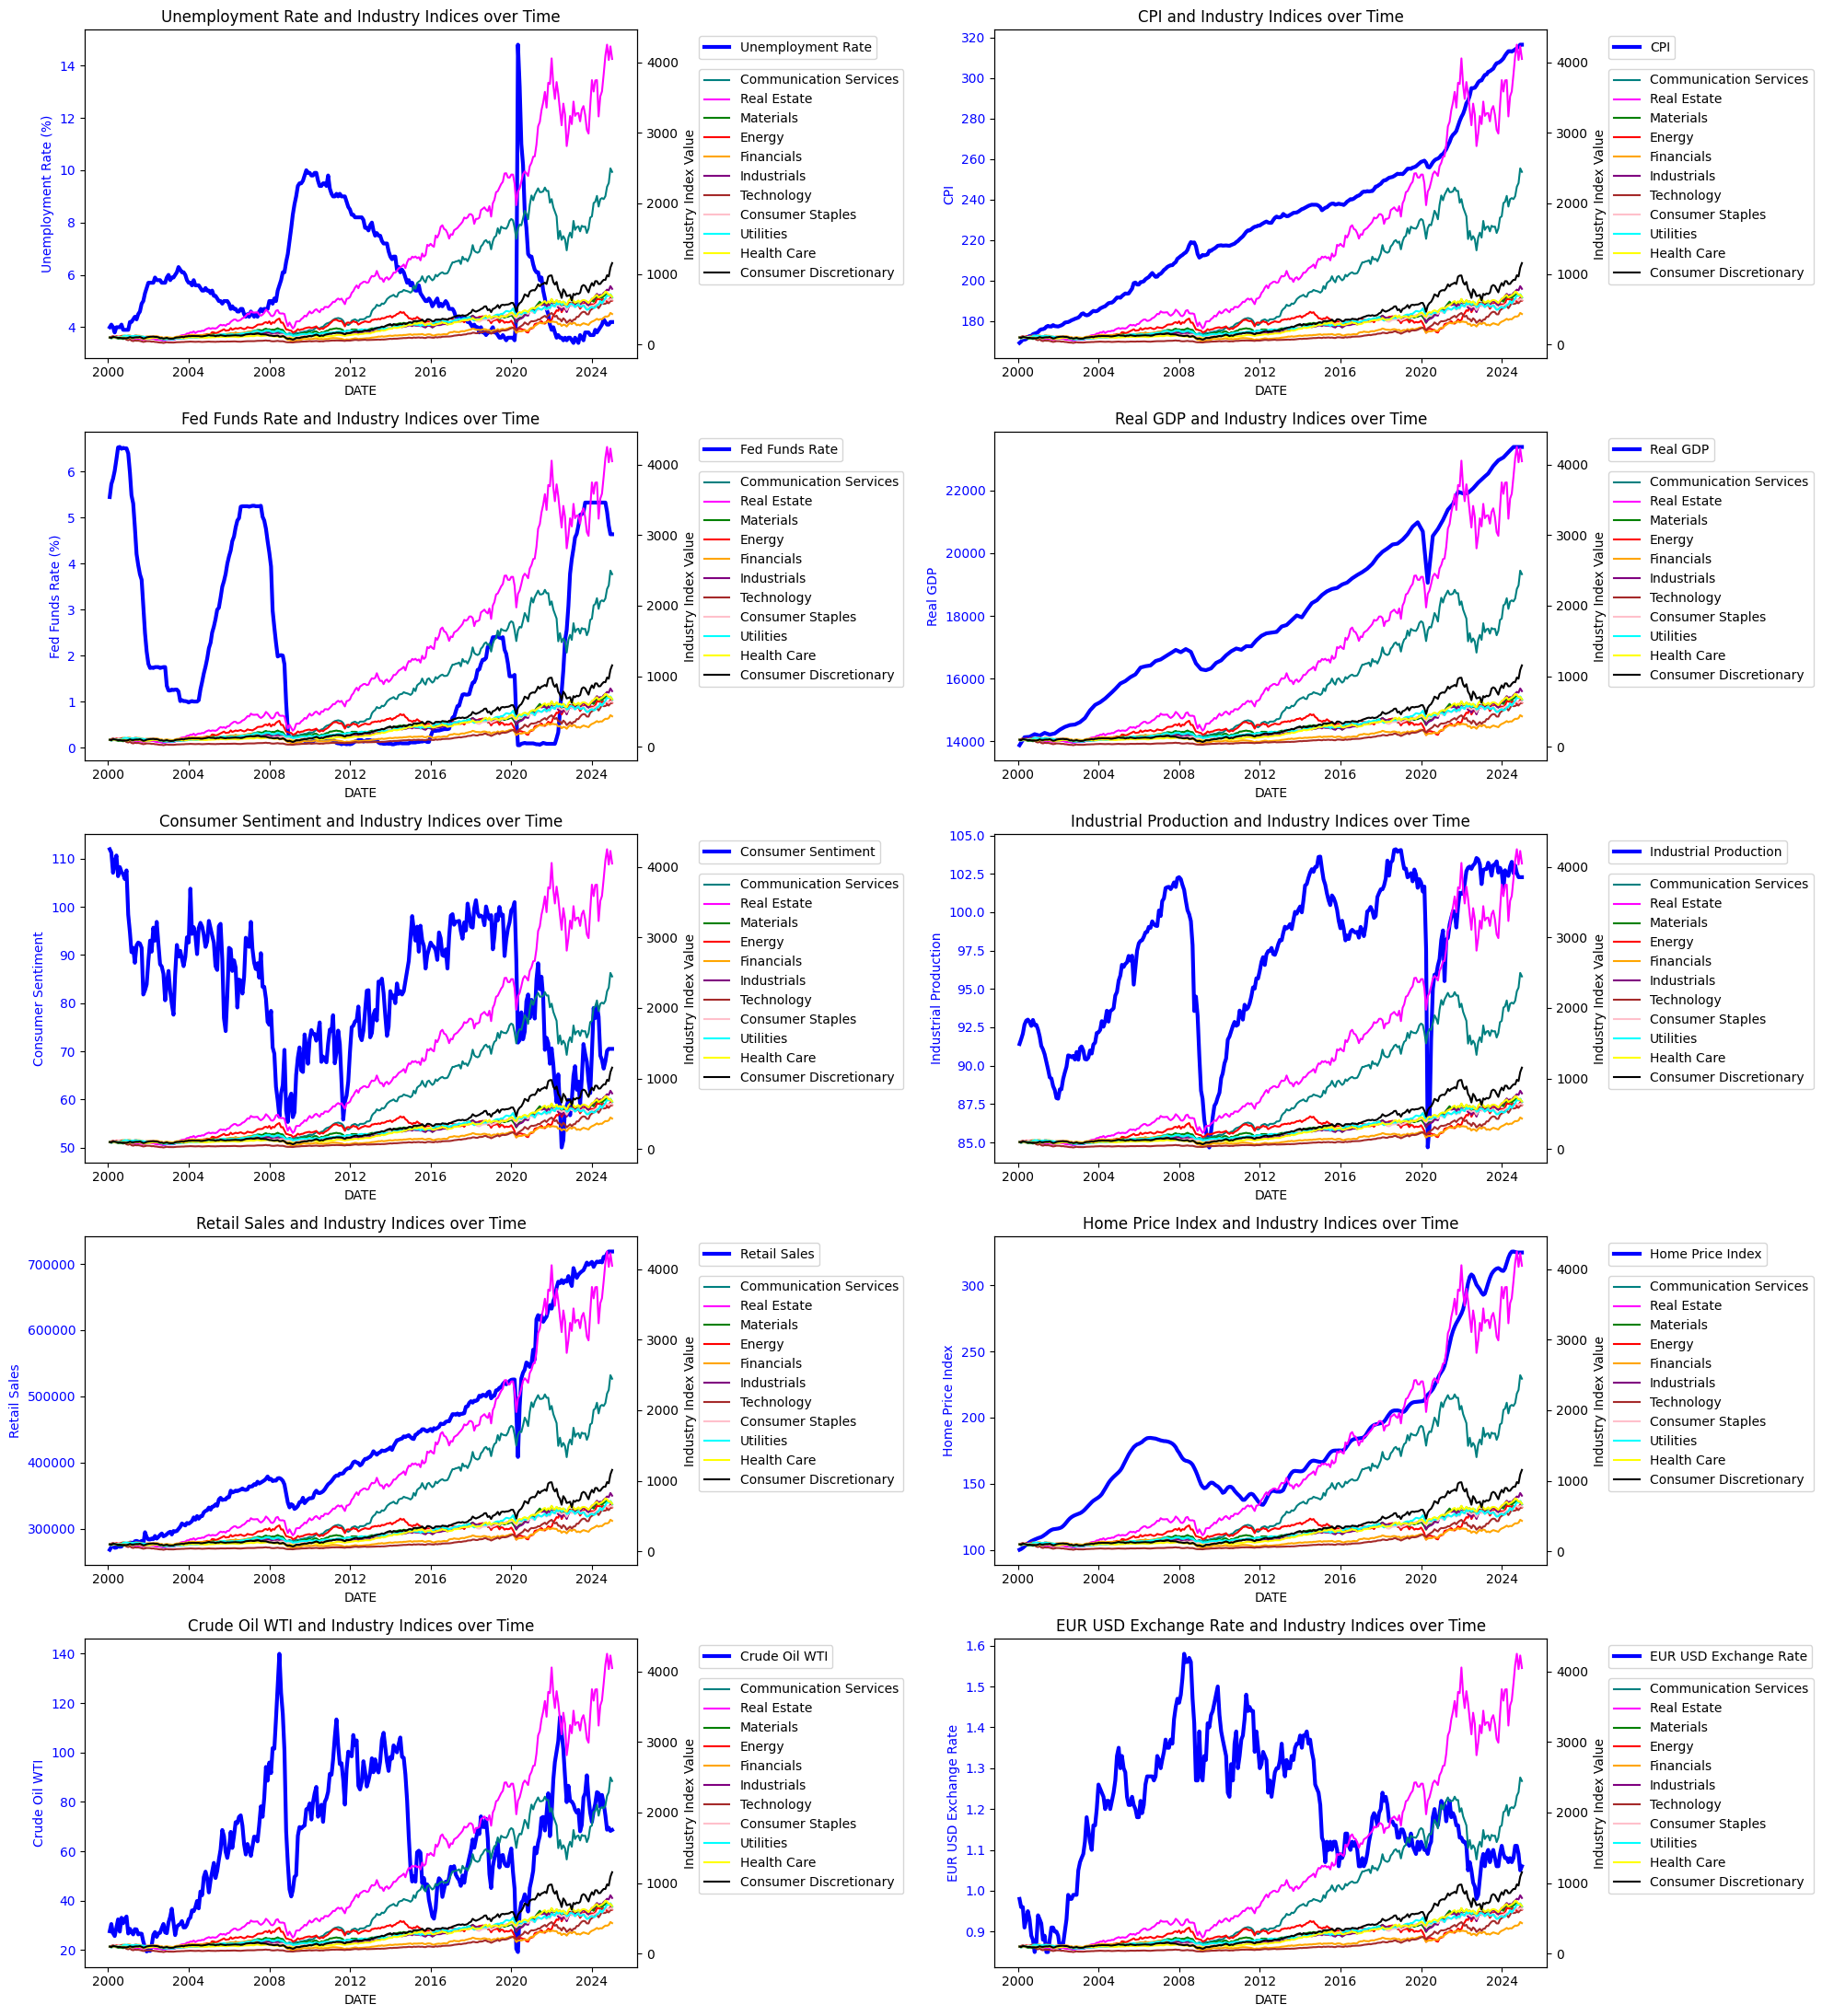

In [39]:
fig, axs = plt.subplots(5, 2, figsize=(20, 22))

# Unemployment Rate
ax1 = axs[0, 0]
ax1.plot(data['DATE'], data['Unemployment_Rate'], color='blue', label='Unemployment Rate', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Unemployment Rate (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.set_title('Unemployment Rate and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# CPI
ax1 = axs[0, 1]
ax1.plot(data['DATE'], data['CPI'], color='blue', label='CPI', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('CPI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.set_title('CPI and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# Fed Funds Rate
ax1 = axs[1, 0]
ax1.plot(data['DATE'], data['Fed_Funds_Rate'], color='blue', label='Fed Funds Rate', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Fed Funds Rate (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.set_title('Fed Funds Rate and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# Real GDP
ax1 = axs[1, 1]
ax1.plot(data['DATE'], data['Real_GDP'], color='blue', label='Real GDP', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Real GDP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.set_title('Real GDP and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# Consumer Sentiment
ax1 = axs[2, 0]
ax1.plot(data['DATE'], data['Consumer_Sentiment'], color='blue', label='Consumer Sentiment', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Consumer Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.set_title('Consumer Sentiment and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# Industrial Production
ax1 = axs[2, 1]
ax1.plot(data['DATE'], data['Industrial_Production'], color='blue', label='Industrial Production', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Industrial Production', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.set_title('Industrial Production and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# Retail Sales
ax1 = axs[3, 0]
ax1.plot(data['DATE'], data['Retail_Sales'], color='blue', label='Retail Sales', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Retail Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
plt.title('Retail Sales and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# Home Price Index
ax1 = axs[3, 1]
ax1.plot(data['DATE'], data['Home_Price_Index'], color='blue', label='Home Price Index', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Home Price Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
plt.title('Home Price Index and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# Crude Oil WTI
ax1 = axs[4, 0]
ax1.plot(data['DATE'], data['Crude_Oil_WTI'], color='blue', label='Crude Oil WTI', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('Crude Oil WTI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
plt.title('Crude Oil WTI and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

# EUR USD Exchange Rate
ax1 = axs[4, 1]
ax1.plot(data['DATE'], data['EUR_USD_Exchange_Rate'], color='blue', label='EUR USD Exchange Rate', linewidth=3)
ax1.set_xlabel('DATE')
ax1.set_ylabel('EUR USD Exchange Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2 = ax1.twinx()
ax2.plot(data['DATE'], data['Communication Services'], label='Communication Services', color='teal')
ax2.plot(data['DATE'], data['Real Estate'], label='Real Estate', color='magenta')
ax2.plot(data['DATE'], data['Materials'], label='Materials', color='green')
ax2.plot(data['DATE'], data['Energy'], label='Energy', color='red')
ax2.plot(data['DATE'], data['Financials'], label='Financials', color='orange')
ax2.plot(data['DATE'], data['Industrials'], label='Industrials', color='purple')
ax2.plot(data['DATE'], data['Technology'], label='Technology', color='brown')
ax2.plot(data['DATE'], data['Consumer Staples'], label='Consumer Staples', color='pink')
ax2.plot(data['DATE'], data['Utilities'], label='Utilities', color='cyan')
ax2.plot(data['DATE'], data['Health Care'], label='Health Care', color='yellow')
ax2.plot(data['DATE'], data['Consumer Discretionary'], label='Consumer Discretionary', color='black')
ax2.set_ylabel('Industry Index Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')
plt.title('EUR USD Exchange Rate and Industry Indices over Time')
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.9))

plt.tight_layout()
plt.show()

From the images above, we can observe that the graphs of CPI, Retail Sales, and the Home Price Index closely align with those of most sectors. Therefore, we have chosen these three indicators for further in-depth analysis.

## 4.1 CPI (Consumer Price Index) ##

We first plot the heat map and cluster map to visualise the correlations between CPI and different industry indices.

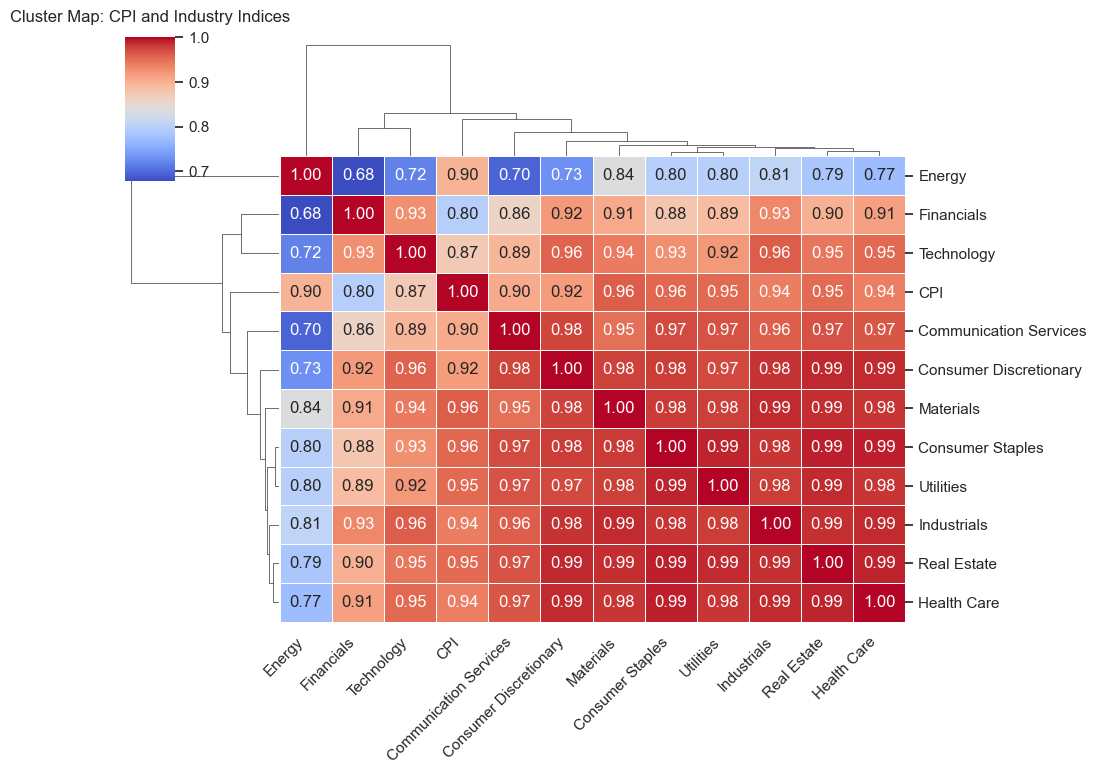

In [40]:
correlations = data[['CPI','Communication Services', 'Real Estate', 'Materials', 'Energy', 'Financials',
                     'Industrials', 'Technology', 'Consumer Staples', 'Utilities',
                     'Health Care', 'Consumer Discretionary']].corr()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True,
            xticklabels=correlations.columns, yticklabels=correlations.columns)

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.title('Correlation Heatmap: CPI and Industry Indices')

cluster_map = sns.clustermap(
    correlations,
    cmap='coolwarm',  
    annot=True,       
    fmt='.2f',        
    linewidths=0.5,   
    figsize=(10, 8),  
    cbar=True         
)
plt.setp(cluster_map.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.title('Cluster Map: CPI and Industry Indices', y=1.05) 
plt.show()

The above two plots highlight the strong correlations between the CPI and various industry indices, with most values above 0.90, indicating a close relationship between inflation and sector performance. Notable high correlations are observed with Consumer Staples, Utilities, and Real Estate, sectors highly sensitive to inflation. However, the Energy sector stands out with relatively lower correlations (e.g., 0.70 with Communication Services and 0.68 with Financials), suggesting its performance is influenced by factors beyond CPI. Overall, the chart underscores the interconnectedness of industries and provides insights into inflation-sensitive sectors and diversification opportunities.

We then examine the three sectors that are most closely correlated with CPI to gain further insights into their relationships.

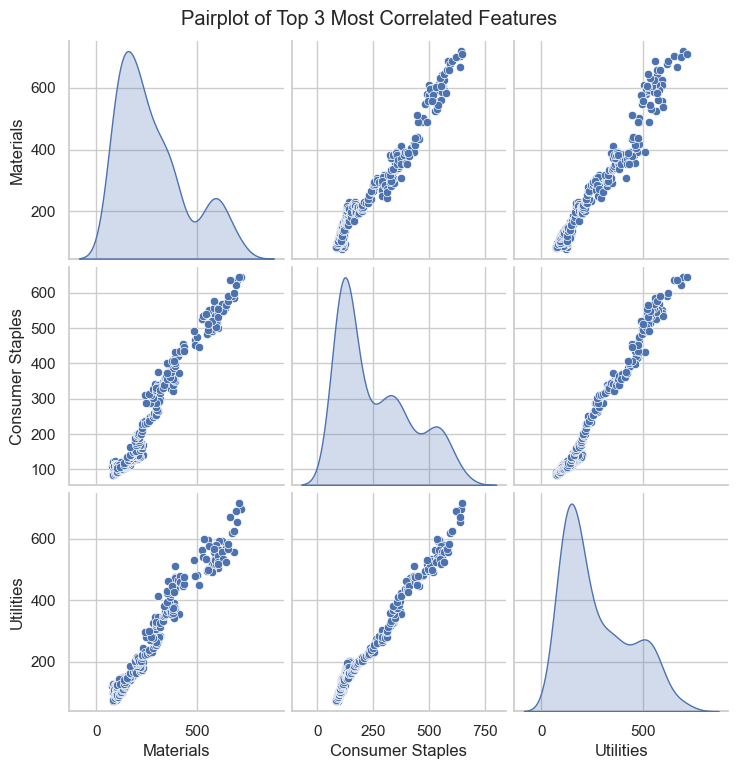

In [41]:
correlation = correlations['CPI'].sort_values(ascending=False)

top_3 = correlation.index[1:4]

warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
sns.pairplot(data[top_3], diag_kind='kde', height=2.5)

plt.suptitle("Pairplot of Top 3 Most Correlated Features", y=1.02)
plt.show()

This pairplot shows the relationships among the top three most correlated industry indices: Materials, Consumer Staples, and Utilities, which exhibit strong positive linear relationships, as seen in the scatterplots. The diagonal plots highlight their distributions, with Materials and Utilities showing slightly bimodal patterns, while Consumer Staples has a unimodal distribution. These industries are closely tied to the Consumer Price Index (CPI), reflecting shared sensitivity to inflation. For example, Consumer Staples is impacted by rising prices of essential goods, while Materials and Utilities are influenced by production and energy costs.

The strong interdependence between these sectors indicates that they tend to move in sync, especially when inflationary pressures are present.Rising costs in one sector, like Consumer Staples, can trigger similar effects in others, such as Materials and Utilities, as they all share common economic drivers, like rising input costs and price increases. Because of this interdependence, these sectors can act as reliable indicators of inflation-driven market trends.  

## 4.2 Retail Sales

Next we will direct our attention to Retail Sales.

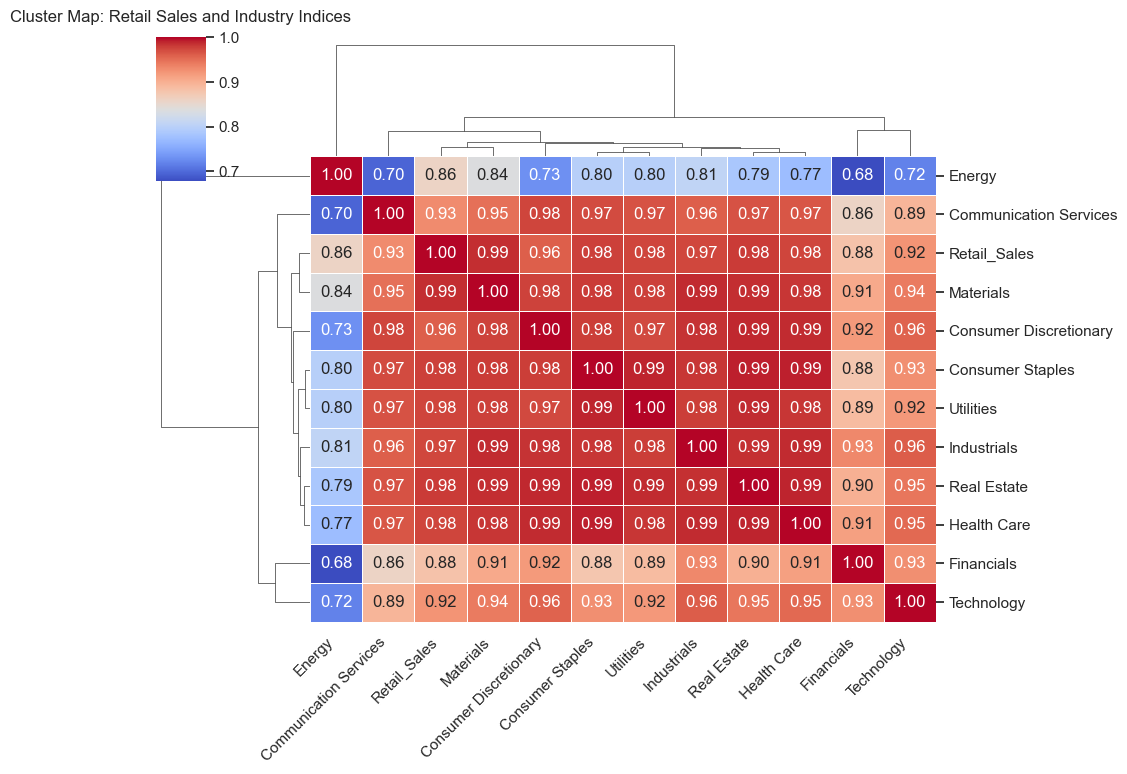

In [42]:
correlations = data[['Retail_Sales','Communication Services', 'Real Estate', 'Materials', 'Energy', 'Financials',
                     'Industrials', 'Technology', 'Consumer Staples', 'Utilities',
                     'Health Care', 'Consumer Discretionary']].corr()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True,
            xticklabels=correlations.columns, yticklabels=correlations.columns)

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.title('Correlation Heatmap: Retail Sales and Industry Indices')

cluster_map = sns.clustermap(
    correlations,
    cmap='coolwarm',  
    annot=True,       
    fmt='.2f',        
    linewidths=0.5,   
    figsize=(10, 8),  
    cbar=True         
)
plt.setp(cluster_map.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.title('Cluster Map: Retail Sales and Industry Indices', y=1.05) 
plt.show()

The above two plots show the correlations between Retail Sales and various industry indices, highlighting strong positive relationships across most sectors. Retail Sales is highly correlated with Consumer Staples, Utilities, and Real Estate (all at 0.98), reflecting their reliance on consumer spending. Conversely, the Energy sector shows relatively weaker correlations (e.g., 0.86 with Retail Sales), suggesting its performance is influenced by external factors beyond consumer behavior. The strong inter-industry correlations, particularly among Materials, Industrials, and Consumer Staples, indicate their shared sensitivity to economic trends driven by retail activity. 

In [43]:
correlation = correlations['Retail_Sales'].sort_values(ascending=False)

top_3 = correlation.index[1:4]

warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
sns.pairplot(data[top_3], diag_kind='kde', height=2.5)

plt.suptitle("Pairplot of Top 3 Most Correlated Features", y=1.02)
plt.show()

This pairplot illustrates the relationships among the top three most correlated industry indices: Materials, Real Estate, and Consumer Staples, which exhibit strong positive linear relationships, as shown in the scatterplots. The diagonal plots highlight their distributions, with Materials and Consumer Staples displaying right-skewed patterns, while Real Estate has a broader distribution. These industries are likely interconnected through shared economic drivers, such as consumer demand, housing market activity, and supply chain dynamics.

The strong interdependence between these sectors suggests that they tend to move in sync, reflecting broader market trends. For instance, rising demand in Consumer Staples could drive up production in Materials, while Real Estate may benefit from increased consumer spending or investment. This alignment indicates that these industries are mutually sensitive to changes in economic conditions.

## 4.3 Home Price Index

In [44]:
correlations = data[['Home_Price_Index','Communication Services', 'Real Estate', 'Materials', 'Energy', 'Financials',
                     'Industrials', 'Technology', 'Consumer Staples', 'Utilities',
                     'Health Care', 'Consumer Discretionary']].corr()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True,
            xticklabels=correlations.columns, yticklabels=correlations.columns)

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.title('Correlation Heatmap: Home Price Index and Industry Indices')

cluster_map = sns.clustermap(
    correlations,
    cmap='coolwarm',  
    annot=True,       
    fmt='.2f',        
    linewidths=0.5,   
    figsize=(10, 8),  
    cbar=True         
)
plt.setp(cluster_map.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.title('Cluster Map: Home Price Index and Industry Indices', y=1.05) 
plt.show()

The heatmap above illustrates the correlations between the Home Price Index and various industry indices, showcasing generally strong positive relationships across most sectors. The Home Price Index is highly correlated with Real Estate, Materials, and Industrials (all at 0.99), underscoring the interconnectedness of housing prices with construction-related industries. In contrast, the Energy sector demonstrates relatively weaker correlations (e.g., 0.79 with the Home Price Index), indicating that its performance is more influenced by external factors like global commodity prices rather than housing market trends. The pronounced inter-industry correlations, particularly among Utilities, Health Care, and Consumer Staples, highlight their collective responsiveness to broader economic and housing dynamics.

In [45]:
correlation = correlations['Home_Price_Index'].sort_values(ascending=False)

top_3 = correlation.index[1:4]

warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
sns.pairplot(data[top_3], diag_kind='kde', height=2.5)

plt.suptitle("Pairplot of Top 3 Most Correlated Features", y=1.02)
plt.show()

This pairplot shows the relationships among the top three most correlated industry indices: Materials, Health Care, and Industrials, which exhibit strong positive linear relationships, as seen in the scatterplots. The diagonal plots highlight their distributions, with Materials and Industrials showing slightly skewed patterns, while Health Care has a sharper, more concentrated peak. These industries are closely tied to the Home Price Index, reflecting shared sensitivity to housing market trends. For example, increased demand for Materials often signals higher construction activity, while Industrials may reflect growth in infrastructure projects, and Health Care could indicate urban population expansion requiring new facilities.

The strong interdependence between these sectors suggests they move in sync, particularly during periods of housing market growth. Rising costs or activity in one sector, such as Materials, can trigger similar effects in others, like Industrials and Health Care, as they share common economic drivers like construction demand, resource availability, and population trends. This interconnectedness makes them reliable indicators of housing market dynamics.

# 5.0 Regression Modelling

Economic indicators are vital tools for analyzing sectoral market performance, offering insights into how industries respond to macroeconomic conditions. Rooted in demand driven economic growth theory, which emphasizes consumer demand as the engine of economic expansion (Keynes, 1936), our study employs regression models to assess the individual impact of specific economic indicators on sector performance. Indicators such as Retail Sales, Consumer Price Index (CPI), Home Price Index, and Real GDP are analyzed independently to isolate their direct influence, holding all else equal. This approach provides a simplified yet rigorous framework for understanding sectoral sensitivities to macroeconomic changes, without delving into the complexities of indicator interplay.

For instance, an increase in retail sales, a key proxy for consumer confidence and spending, may signal heightened demand for goods and services, directly benefiting sectors such as consumer discretionary and materials through increased production activity. By focusing on individual indicators, the model avoids confounding effects and provides clarity on how specific economic variables drive sector performance. While the broader economic environment involves intricate interactions between indicators, these are beyond the scope of our model, which aims to offer a focused and precise analysis of isolated relationships.

This methodology ensures a robust foundation for understanding sectoral dynamics within the framework of demand driven economic theory. The findings serve as a starting point for investors and policymakers to interpret economic signals, anticipate sector trends, and align strategies with market conditions, while acknowledging the model's limitations in addressing complex macroeconomic interdependencies.

In [47]:
merged_data = pd.read_csv('cleaned_combined_data.csv')

merged_data.rename(columns={'observation_date': 'Date'}, inplace=True)


## 5.1 Model 1: Impact of Retail Sales on Materials Sector

The impact of retail sales on the materials sector underscores the crucial link between consumer demand and industrial activity. As retail sales rise, increased production needs drive demand for raw materials, making this sector highly sensitive to consumer spending trends. By analysing this relationship through a demand-driven economic growth lens, we aim to quantify how shifts in retail activity influence materials sector performance.

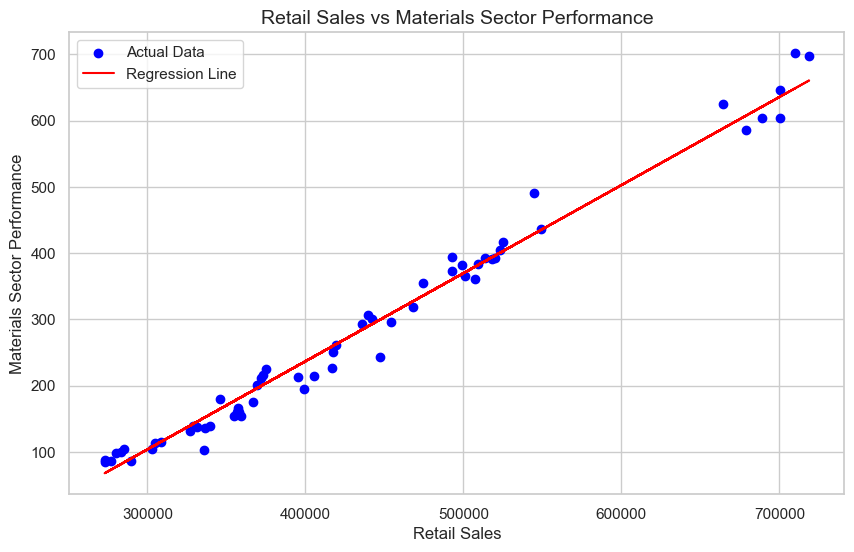

In [56]:
# Extract X (Retail Sales) and Y (Materials Sector Performance)
X = merged_data[['Retail_Sales']]
Y = merged_data[['Materials']]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predictions and evaluation
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
coefficient = model.coef_[0][0]
intercept = model.intercept_[0]

# Plot the relationship between Retail Sales and Materials Sector Performance
plt.figure(figsize=(10, 6))

# Scatter plot of actual data
plt.scatter(X_test, Y_test, color='blue', label='Actual Data')

# Regression line
plt.plot(X_test, Y_pred, color='red', label='Regression Line')

# Titles and labels
plt.title("Retail Sales vs Materials Sector Performance", fontsize=14)
plt.xlabel("Retail Sales", fontsize=12)
plt.ylabel("Materials Sector Performance", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The graph above illustrates the relationship between retail sales and the performance of the materials sector. The blue dots represent the actual data points, while the red line indicates the regression model's predictions. This visualisation provides a clearer understanding of how retail sales impact the materials sector, helping investors assess potential trends.

In [57]:
# Add a constant to the independent variable for statsmodels regression
X_with_constant = sm.add_constant(X)

# Fit the model using statsmodels
model_sm = sm.OLS(Y, X_with_constant).fit()

# Get the summary of the regression analysis as text
model_summary_text = model_sm.summary().as_text()

# Print the summary
print(model_summary_text)


                            OLS Regression Results                            
Dep. Variable:              Materials   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 1.120e+04
Date:                Sun, 05 Jan 2025   Prob (F-statistic):          2.09e-238
Time:                        15:51:33   Log-Likelihood:                -1419.1
No. Observations:                 300   AIC:                             2842.
Df Residuals:                     298   BIC:                             2850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -297.6999      5.692    -52.304   

Regression Robustness and Consistency Analysis:

* R-squared: 0.974 indicates that 97.4% of the variation in materials sector performance is explained by retail sales, suggesting a very strong fit.
* Adjusted R-squared: 0.974 confirms the robustness of the model even when adjusting for the number of predictors.
* F-statistic: 1.120e+04 with a p-value near zero confirms the model's overall significance.

Coefficients:

* The coefficient for Retail_Sales (0.0013) is statistically significant with a p-value of 0.000, indicating a consistent relationship between retail sales and materials sector performance.
* The constant term (-298.1553) also has statistical significance, suggesting its importance in the regression equation.
* Durbin-Watson: 0.533 points to positive autocorrelation, which may indicate a need for further diagnostics for time-series data.
* Condition Number: 1.62e+06 indicates potential multicollinearity or numerical issues.

Key Takeaways for Investors: 

The model demonstrates a very strong relationship between retail sales and materials sector performance. However, signs of autocorrelation and potential multicollinearity suggest that investors should consider other factors or incorporate more advanced econometric methods to validate the predictive power of this relationship over time.

## 5.2 Model 2: Impact of Consumer Price Index on Consumer Staples

The impact of CPI on the consumer staples sector reflects the essential nature of staple goods during periods of inflation. As CPI rises, companies in this sector often benefit from pricing power and stable demand, maintaining resilience even amid economic uncertainty. By analysing this relationship, we aim to quantify how changes in inflation influence the performance of consumer staples.

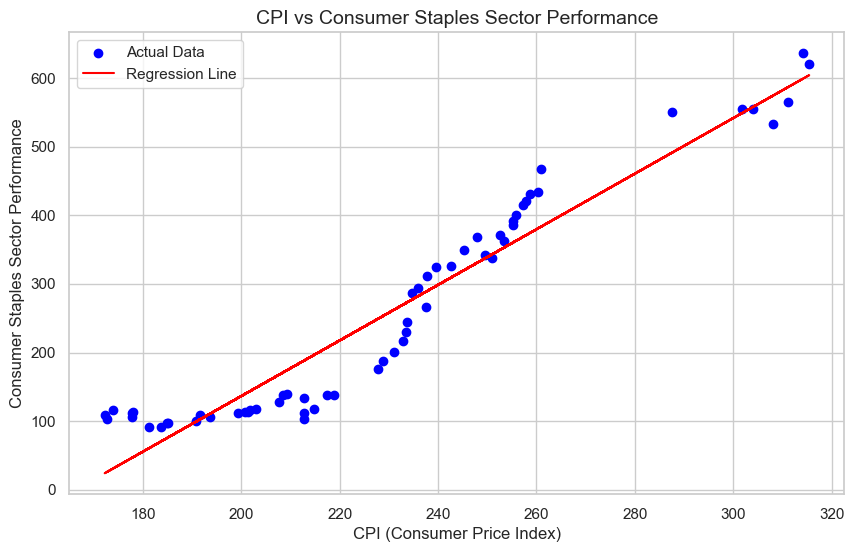

In [58]:
# Extract X (CPI) and Y (Consumer Staples Sector Performance)
X_cpi = merged_data[['CPI']]
Y_consumer_staples = merged_data[['Consumer Staples']]

# Train-test split
X_train_cpi, X_test_cpi, Y_train_consumer_staples, Y_test_consumer_staples = train_test_split(
    X_cpi, Y_consumer_staples, test_size=0.2, random_state=42
)

# Regression model
model_cpi = LinearRegression()
model_cpi.fit(X_train_cpi, Y_train_consumer_staples)

# Predictions and evaluation
Y_pred_consumer_staples = model_cpi.predict(X_test_cpi)
mse_cpi = mean_squared_error(Y_test_consumer_staples, Y_pred_consumer_staples)
coefficient_cpi = model_cpi.coef_[0][0]
intercept_cpi = model_cpi.intercept_[0]

# Plot the relationship between CPI and Consumer Staples Sector Performance
plt.figure(figsize=(10, 6))

# Scatter plot of actual data
plt.scatter(X_test_cpi, Y_test_consumer_staples, color='blue', label='Actual Data')

# Regression line
plt.plot(X_test_cpi, Y_pred_consumer_staples, color='red', label='Regression Line')

# Titles and labels
plt.title("CPI vs Consumer Staples Sector Performance", fontsize=14)
plt.xlabel("CPI (Consumer Price Index)", fontsize=12)
plt.ylabel("Consumer Staples Sector Performance", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The graph above visualises the relationship between CPI (Consumer Price Index) and consumer staples sector performance. The blue dots represent actual data points, while the red line illustrates the regression model's predictions, highlighting the positive correlation between inflation and sector performance. This provides a clear depiction of the model's analysis.

In [59]:
# Add a constant to the independent variable for statsmodels regression
X_cpi_with_constant = sm.add_constant(X_cpi)

# Fit the model using statsmodels
model_cpi_sm = sm.OLS(Y_consumer_staples, X_cpi_with_constant).fit()

# Get the summary of the regression analysis
model_cpi_summary_text = model_cpi_sm.summary().as_text()
print(model_cpi_summary_text)

                            OLS Regression Results                            
Dep. Variable:       Consumer Staples   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     3108.
Date:                Sun, 05 Jan 2025   Prob (F-statistic):          1.11e-159
Time:                        15:58:18   Log-Likelihood:                -1585.6
No. Observations:                 300   AIC:                             3175.
Df Residuals:                     298   BIC:                             3183.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -672.7625     16.929    -39.740      0.0

Regression Robustness and Consistency Analysis:

* R-squared: 0.912 indicates that 91.2% of the variation in the Consumer Staples sector performance is explained by changes in the Consumer Price Index (CPI), showcasing a strong fit.
* Adjusted R-squared: 0.912 confirms the robustness of the model, even when adjusted for the simplicity of a single predictor.
* F-statistic: 3105 with a near-zero p-value indicates that the model as a whole is statistically significant.

Coefficients:

* The coefficient for CPI (4.0515) is highly significant, with a t-statistic of 55.722 and a p-value of 0.000, showing a consistent positive relationship between inflation and Consumer Staples performance.
* The constant term (-673.1747) is also statistically significant, reflecting the baseline performance of the sector when CPI is zero (a theoretical construct).
* Durbin-Watson: 0.056 indicates potential positive autocorrelation in the residuals, which suggests further diagnostics are needed for time-series applications.
* Condition Number: 1.43e+03, while elevated, does not strongly indicate multicollinearity concerns.

Key Takeaway for Investors: 

The strong positive relationship between CPI and the Consumer Staples sector highlights its resilience during periods of inflation. As prices rise, companies in this sector tend to maintain stable demand and pricing power, making it a reliable choice for portfolio allocation during inflationary environments. However, investors should be cautious of potential time-series effects, as the model suggests some autocorrelation, which could influence predictions over time. Incorporating this insight into broader macroeconomic strategies can enhance investment decisions, particularly in uncertain or inflationary periods.

## 5.3 Model 3: Impact of Home Price Index and Real GDP on Real Estate Sector

The impact of economic growth and housing market dynamics on the Real Estate sector highlights the interconnected nature of macroeconomic indicators and sectoral performance. As GDP growth accelerates, it signals increased economic activity, often driving demand for real estate, while housing price trends reflect broader market conditions and affordability. By analysing these relationships through regression models, we aim to quantify how changes in GDP growth and housing prices influence the performance of the Real Estate sector, providing insights into its sensitivity to key economic drivers.

* Model A: Y = Real Estate, X = log(Real GDP) + log(Housing Price Index)
* Model B: Y = Real Estate, X = log(Real GDP) + Housing Price Index
* Model C: Y = Real Estate, X = log(Real GDP)
* Model D: Y = Real Estate, X = Housing Price Index

The first two models aim to evaluate the hypothesis that both log(Real GDP) and log(Housing Price Index) are significantly correlated with real estate sector performance. By including these variables together, we assess their combined and individual explanatory power. However, based on preliminary scatter plot observations, it appears that the housing price index may have limited correlation with real estate performance. This motivated the creation of the next two models, which isolate each independent variable to test their individual relationships with the dependent variable.

By comparing regression results, we can critically examine the hypothesis and potentially confirm that the housing price index is less predictive of real estate performance. This suggests that housing prices may act more as a lagging outcome of broader market forces, such as demand and weakening GDP—rather than a direct driver of sector performance. Moreover, the weak correlation may indicate that the real estate sector's performance is influenced by other, more complex factors. These findings not only question the predictive utility of the housing price index in this context but also encourage further exploration of alternative economic indicators that might better explain real estate market trends. This nuanced approach ensures a deeper understanding of sectoral dynamics.

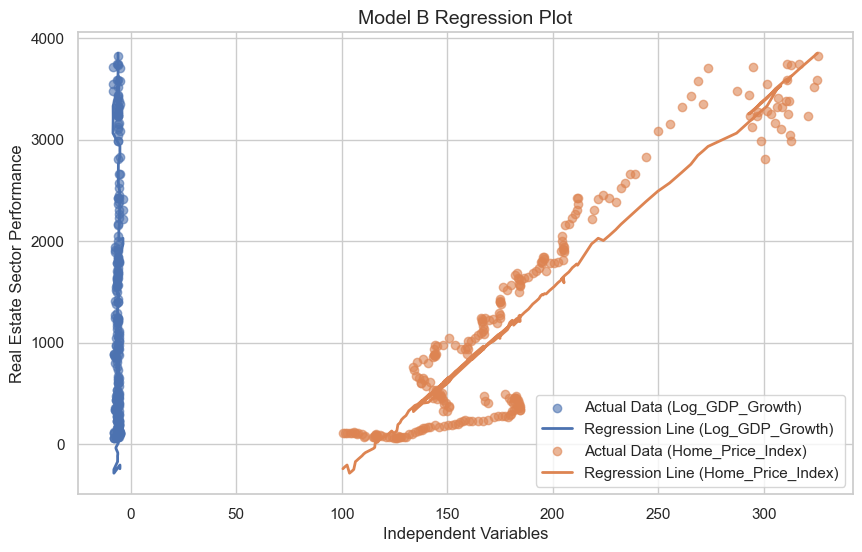

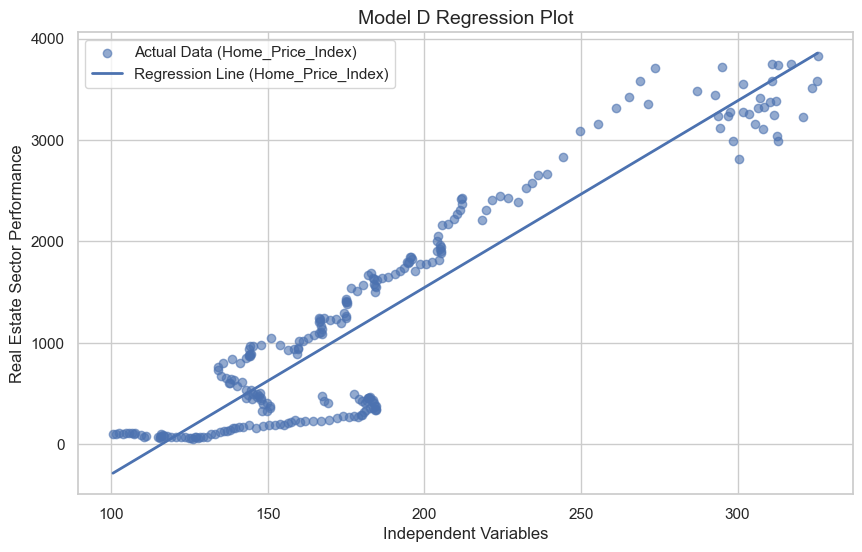

In [60]:
# Calculate GDP Growth
merged_data['GDP_Growth'] = merged_data['Real_GDP'].pct_change()

# Log transformation of GDP Growth and Home Price Index
merged_data['Log_GDP_Growth'] = merged_data['GDP_Growth'].apply(
    lambda x: np.log(x) if x > 0 else None
)
merged_data['Log_Home_Price_Index'] = merged_data['Home_Price_Index'].apply(
    lambda x: np.log(x) if x > 0 else None
)

# Drop rows with missing or invalid values
cleaned_data = merged_data.dropna(subset=['Log_GDP_Growth', 'Log_Home_Price_Index', 'Home_Price_Index', 'Real Estate'])

# Define the dependent variable
Y = cleaned_data[['Real Estate']]

# Define models
models = {
    "Model A": cleaned_data[['Log_GDP_Growth', 'Log_Home_Price_Index']],
    "Model B": cleaned_data[['Log_GDP_Growth', 'Home_Price_Index']],
    "Model C": cleaned_data[['Log_GDP_Growth']],
    "Model D": cleaned_data[['Home_Price_Index']]
}

# Fit regression models and collect results
results = {}
for name, X in models.items():
    X_with_const = sm.add_constant(X)  # Add constant for intercept
    model = sm.OLS(Y, X_with_const).fit()
    results[name] = model

# Generate comparative results table
comparative_table = pd.DataFrame({
    "Model": [name for name in results.keys()],
    "R-squared": [model.rsquared for model in results.values()],
    "Adj. R-squared": [model.rsquared_adj for model in results.values()],
    "F-statistic": [model.fvalue for model in results.values()],
    "P(F-statistic)": [model.f_pvalue for model in results.values()],
    "AIC": [model.aic for model in results.values()],
    "BIC": [model.bic for model in results.values()]
})

# Save the comparative results table
comparative_table.to_csv("comparative_regression_results.csv", index=False)

# Plot each regression model
for name, X in models.items():
    X_with_const = sm.add_constant(X)
    predictions = results[name].predict(X_with_const)

    plt.figure(figsize=(10, 6))
    for col in X.columns:
        plt.scatter(X[col], Y, alpha=0.6, label=f"Actual Data ({col})")
        plt.plot(X[col], predictions, label=f"Regression Line ({col})", linewidth=2)

    plt.title(f"{name} Regression Plot", fontsize=14)
    plt.xlabel("Independent Variables", fontsize=12)
    plt.ylabel("Real Estate Sector Performance", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

Model A - This model incorporates logarithmic transformations for both variables to capture potential non-linear relationships and provide interpretable elasticities.

Model B - This approach combines a log-transformed GDP growth with the raw housing price index to test whether the housing index's linearity affects its explanatory power.

Model C - This simpler model isolates the impact of economic growth on real estate performance, focusing solely on GDP growth in logarithmic form.

Model D - This model evaluates the direct relationship between housing price index and real estate performance to test its standalone ex

In [61]:
# Fit OLS models and collect summaries
ols_results = {}
for name, X in models.items():
    X_with_const = sm.add_constant(X)  # Add constant for intercept
    model = sm.OLS(Y, X_with_const).fit()
    ols_results[name] = model

# Create a comparative table for OLS regression results
ols_comparison_table = pd.DataFrame({
    "Model": [name for name in ols_results.keys()],
    "R-squared": [model.rsquared for model in ols_results.values()],
    "Adj. R-squared": [model.rsquared_adj for model in ols_results.values()],
    "F-statistic": [model.fvalue for model in ols_results.values()],
    "P(F-statistic)": [model.f_pvalue for model in ols_results.values()],
    "AIC": [model.aic for model in ols_results.values()],
    "BIC": [model.bic for model in ols_results.values()]
})

# Display the OLS Regression Comparison Table
print(ols_comparison_table)

     Model  R-squared  Adj. R-squared  F-statistic  P(F-statistic)  \
0  Model A   0.827017        0.825644   602.393907    9.739448e-97   
1  Model B   0.855554        0.854407   746.296565   1.327407e-106   
2  Model C   0.015642        0.011751     4.020336    4.601998e-02   
3  Model D   0.855045        0.854472  1492.365408   4.263722e-108   

           AIC          BIC  
0  3862.479492  3873.103282  
1  3816.506184  3827.129975  
2  4303.872052  4310.954579  
3  3815.403231  3822.485758  


Robustness and Consistency Analysis:

The OLS regression results provide a detailed comparison of how well different combinations of independent variables Log{Real GDP}, Log{Housing Price Index}, and {Housing Price Index} explain Real Estate sector performance. Models A and B demonstrate strong explanatory power, with high R2 and adjusted R2 values, indicating that the combination of GDP growth and housing price dynamics significantly impacts the sector. However, the weaker performance of Model C (R2 = 0.0156) confirms that GDP growth alone is insufficient to explain the sector's behavior, while Model D (R2 = 0.855) highlights the strong standalone relationship of the Housing Price Index with Real Estate performance.

Incorporating lagged variables in Models A and B ( t-1 ) and ( t-2 ) provided additional insight. Although lagged models performed reasonably well, they showed slightly lower R2 and adjusted R2 values compared to Model B, suggesting that housing price dynamics act more as a concurrent indicator than a lagging one.

Testing for multicollinearity revealed low variance inflation factor (VIF) values approx 1.02 for Log{GDP Growth} and Log{Housing Price Index}, confirming that these variables independently contribute to the regression without redundancy.

Furthermore, these findings reveal that relying solely on demand side economic theory may not fully capture market dynamics in the real estate sector. While demand side factors, like GDP growth, play a crucial role, the Housing Price Index's behavior suggests significant supply side influences, such as construction activity, housing inventory, and regulatory factors. This underscores the importance of balancing demand side and supply side economic theories when analysing financial market dynamics.

Key Takeaway for Investors:

The analysis underscores the importance of considering housing market dynamics when assessing Real Estate sector performance. Model B emerges as the most robust and consistent, combining Log{Real GDP} and {Housing Price Index} to effectively explain sector behaviour. However, the findings suggest that the Housing Price Index may act more as a reflection of broader market conditions than as a direct driver. For investors, this indicates the need to explore additional factors, such as interest rates, consumer sentiment, or construction activity, to build a more comprehensive predictive model for the sector. Balancing demand side and supply side economic insights is essential to understanding the complexities of financial markets. This approach allows investors to better navigate the interplay of macroeconomic factors, ensuring a holistic perspective when making investment decisions in dynamic sectors like real estate.

## 6. Conclusion ##

This project has systematically explored the intricate relationship between macroeconomic indicators and the performance of various business sectors within the U.S. stock market from 2000 to 2024. By dissecting sectoral performance across three distinct economic eras—pre-financial crisis (2000–2008), financial crisis and recovery (2008–2020), and the COVID-19 pandemic and post-pandemic period (2020–2024)—we have illuminated the varying degrees of resilience and adaptability exhibited by different sectors in response to macroeconomic fluctuations.

Key Findings:

Sector Performance Across Economic Eras:

* Era 1 (2000–2008): The Real Estate and Energy sectors outperformed others, driven by the real estate bubble and escalating global energy demand. In contrast, the Technology sector struggled due to the aftermath of the dot-com bubble.
* Era 2 (2008–2020): The Financials sector bore the brunt of the 2008 financial crisis but saw the Communication Services sector emerge as a standout performer during the recovery phase, capitalizing on low borrowing costs and technological innovations.
* Era 3 (2020–2024): The Technology sector led the market recovery post-COVID-19, bolstered by advancements in artificial intelligence and increased investor focus on transformative technologies. The Energy sector experienced significant volatility, reflecting geopolitical tensions and fluctuating oil prices.

Influence of Macroeconomic Indicators:

* Consumer Price Index (CPI): Exhibited strong positive correlations with Consumer Staples, Utilities, and Real Estate, indicating these sectors' sensitivity to inflationary pressures.
* Retail Sales: Showed robust relationships with Consumer Staples, Utilities, and Real Estate, underscoring the dependence of these sectors on consumer spending.
* Home Price Index and Real GDP: Demonstrated significant impacts on the Real Estate sector, highlighting the sector's responsiveness to economic growth and housing market dynamics.

Regression Modeling Insights:

* Retail Sales and Materials Sector: The regression model revealed a strong positive relationship (R² = 0.974), emphasizing the sector's dependence on consumer demand. However, issues such as autocorrelation suggest the need for more sophisticated modeling techniques.
* CPI and Consumer Staples Sector: A robust positive correlation (R² = 0.912) underscores the sector's resilience during inflationary periods, although autocorrelation in residuals indicates potential model refinements.
* Home Price Index and Real GDP on Real Estate Sector: Multiple regression models confirmed the significant impact of both economic growth and housing prices on sector performance, with Model B (combining log-transformed GDP and Housing Price Index) offering the most comprehensive explanation.

Implications:

For investors, understanding these relationships is crucial for portfolio diversification and risk management. Sectors such as Technology and Consumer Staples demonstrate strong performance under specific economic conditions, offering opportunities for strategic allocation. Policymakers can leverage these insights to anticipate sectoral impacts of macroeconomic policies, enabling more informed decision-making to foster economic stability and growth.

Limitations:

While the study provides valuable insights, it is constrained by the simplicity of the regression models, which consider macroeconomic indicators in isolation. The presence of autocorrelation and potential multicollinearity in some models indicates that more advanced econometric techniques could enhance the robustness of the findings. Additionally, the analysis primarily focuses on quantitative data, potentially overlooking qualitative factors such as regulatory changes and technological disruptions.

Future Research:

Future studies could incorporate multivariate regression models to capture the interplay between multiple macroeconomic indicators simultaneously, addressing issues of autocorrelation and multicollinearity. Incorporating machine learning techniques could also enhance predictive accuracy and uncover non-linear relationships. Furthermore, expanding the analysis to include global macroeconomic factors and sector-specific qualitative variables would provide a more comprehensive understanding of the determinants of sectoral performance.

In conclusion, this project underscores the pivotal role of macroeconomic indicators in shaping the performance of business sectors within the U.S. stock market. By elucidating these relationships, the study offers a foundational framework for investors, policymakers, and stakeholders to navigate the complexities of the financial landscape, fostering informed decision-making in an ever-evolving economic environment.